In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [90]:
from config import plot_config
from preprocessing.data_loader import DataLoader, DatasetConfig, SplitConfig
from preprocessing.outliers import replace_outliers_iqr
from utils.utils import (print_numerical_features_range, evaluate_model, evaluate_all_models,
                         analyze_null_values, impute_missing_values, train_valid_split, remove_negative_values,
                         apply_feature_engineering, save_processed_data, calculate_class_weights, normalize_data)

from utils.visuals import (analyze_categorical_variables, plot_numerical_distributions, plot_correlation_heatmap, 
                           plot_outliers_analysis, plot_lambda_tuning )
from models.logistic_regression import LogisticRegression, LogisticRegressionConfig
from evaluation.cross_validation import cross_validate_lambda
from evaluation.metrics import f1_score
from models.logistic_regression import LogisticRegression, LogisticRegressionConfig

from preprocessing.data_loader import DataLoader, DatasetConfig, SplitConfig
from preprocessing.rebalancing import (
    RandomUnderSampler, 
    RandomOverSampler, 
    SMOTE, 
    SMOTEConfig,
    RebalancingConfig
)
from utils.utils import evaluate_model


In [91]:

def process_training_data(train_df, valid_df, target_column="Diagnosis", encode_categorical=True):
    # Resetear índices
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)
    
    # Separar características y variable objetivo
    X_train = train_df.drop(columns=[target_column])
    y_train = train_df[target_column].to_numpy()
    
    X_val = valid_df.drop(columns=[target_column])
    y_val = valid_df[target_column].to_numpy()
    
    # Codificar variables categóricas
    if encode_categorical:
        X_train_encoded = DataLoader.encode_categorical(X_train).to_numpy()
        X_val_encoded = DataLoader.encode_categorical(X_val).to_numpy()
    else:
        X_train_encoded = X_train.to_numpy()
        X_val_encoded = X_val.to_numpy()
    
    return X_train_encoded, y_train, X_val_encoded, y_val


In [92]:
def plot_data_analysis_all_visualizations(df, numerical_cols, target_column, features_to_plot, output_dir, fig_output_dir_p1, fig_params={}):

    
    dist_params = fig_params.get("dist_params", {
        "filename": "numerical_distributions_outliers.png",
        "features_to_plot":features_to_plot,
        "tick_fontsize": 18,
        "label_fontsize": 18,
        "title_fontsize": 18,
        "title": " ",
        "figsize": (16, 5)
    })

   
    
    
    # Plot numerical distributions
    fig1 = plot_numerical_distributions(
        df,
        numerical_cols,
        target_column,
        output_dir=output_dir,
        **dist_params
    )
    plt.show()

    heatmap_params = fig_params.get("heatmap_params", {
            "label_fontsize": 18,
            "title_fontsize": 18,
            "tick_fontsize": 18,
            "cbar_fontsize": 18,
            "annot_fontsize": 18,
            "figsize": (18, 12),
            "title": " ",
            "filename": "correlation_heatmap_numerical_features_outliers.png"
        })

    # Plot correlation heatmap
    fig2 = plot_correlation_heatmap(
        df,
        numerical_cols + [target_column],
        output_dir=fig_output_dir_p1,
        **heatmap_params
    )
    plt.show()


    outlier_params = fig_params.get("outlier_params", {
        "filename": "boxplots_outliers_analysis.png",
        "features_to_plot":features_to_plot,
        "figsize": (16, 5)
    })

    # Plot outliers analysis
    fig3 = plot_outliers_analysis(
        df=df,
        save_dir=fig_output_dir_p1,
        **outlier_params
    )
    return fig1, fig2, fig3


%% Configuración de Directorios y Variables Globales

In [93]:
fig_output_dir_p1 = "./figures/p1"
os.makedirs(fig_output_dir_p1, exist_ok=True)
current_dir = Path.cwd()
data_dir = current_dir.parent / "data"
data_dir = data_dir.resolve()
data_dir_p1 = data_dir / "p1"

# Punto 1.1: Inicialización del Dataset

In [94]:
config_cell_diagnosis = DatasetConfig(
    data_dir=data_dir_p1,
    target_column="Diagnosis",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)
loader_cell_diagnosis = DataLoader(config_cell_diagnosis)
loader_cell_diagnosis.read_data(
    dev_file="raw/cell_diagnosis_balanced_dev.csv",
    test_file="raw/cell_diagnosis_balanced_test.csv",
    splitted=False
)
cell_diagnosis_balanced_dev_outliers, cell_diagnosis_balanced_test_outliers = loader_cell_diagnosis.get_pandas_data(splitted=False)

%% Análisis de Valores Nulos y División Train/Valid

In [95]:
cell_diagnosis_balanced_for_train_outliers, cell_diagnosis_balanced_for_valid_outliers = train_valid_split(
    cell_diagnosis_balanced_dev_outliers, test_size=0.2, random_state=12
)
analyze_null_values(
    [cell_diagnosis_balanced_for_train_outliers, cell_diagnosis_balanced_test_outliers],
    ["conjunto de train", "conjunto de prueba"]
);

Valores nulos en conjunto de train:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                258           19.38
1             CellShape                253           19.01
2        NucleusDensity                235           17.66
3      ChromatinTexture                240           18.03
4         CytoplasmSize                245           18.41
5          CellAdhesion                234           17.58
6           MitosisRate                261           19.61
7       NuclearMembrane                248           18.63
8          GrowthFactor                239           17.96
9      OxygenSaturation                229           17.21
10      Vascularization                246           18.48
11  InflammationMarkers                252           18.93
12            Diagnosis                  0            0.00
13             CellType                202           15.18
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo      1228           92.26
1           Muestras sin valores nulos       103            7.74
2                    Total de muestras      1331          100.00



Valores nulos en conjunto de prueba:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                 35           18.92
1             CellShape                 41           22.16
2        NucleusDensity                 32           17.30
3      ChromatinTexture                 35           18.92
4         CytoplasmSize                 33           17.84
5          CellAdhesion                 29           15.68
6           MitosisRate                 36           19.46
7       NuclearMembrane                 25           13.51
8          GrowthFactor                 40           21.62
9      OxygenSaturation                 31           16.76
10      Vascularization                 40           21.62
11  InflammationMarkers                 36           19.46
12            Diagnosis                  0            0.00
13             CellType                 31           16.76
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo       172           92.97
1           Muestras sin valores nulos        13            7.03
2                    Total de muestras       185          100.00

In [96]:
X_train_cell_diagnosis_balanced_for_cross_validation = cell_diagnosis_balanced_for_train_outliers.drop(columns=["Diagnosis"])


y_train_cell_diagnosis_balanced_for_cross_validation = cell_diagnosis_balanced_for_train_outliers["Diagnosis"]


%% Imputación de Valores Faltantes

In [97]:
cell_diagnosis_balanced_for_train_outliers, cell_diagnosis_balanced_for_valid_outliers, cell_diagnosis_balanced_test_outliers = impute_missing_values(
    cell_diagnosis_balanced_for_train_outliers,
    cell_diagnosis_balanced_for_valid_outliers,
    cell_diagnosis_balanced_test_outliers,
    knn_neighbors=8,
    knn_weights="distance"
)

Missing values before imputation:
Train: 3142 missing values
Valid: 821 missing values
Test: 444 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


%% Actualización y Guardado de Datos Preprocesados

In [98]:

# Uso de la función
data_dict = {
    'df_train': cell_diagnosis_balanced_for_train_outliers,
    'df_valid': cell_diagnosis_balanced_for_valid_outliers,
    'df_test': cell_diagnosis_balanced_test_outliers
}

save_processed_data(
    loader=loader_cell_diagnosis,
    data_dict=data_dict,
    data_dir=data_dir_p1,
    dataset_name="cell_diagnosis_balanced",
    processing_type="preprocessed"
)

%% Recarga de Datos Preprocesados

In [99]:
loader_cell_diagnosis.read_data(
    train_file="preprocessed/cell_diagnosis_balanced_train.csv",
    valid_file="preprocessed/cell_diagnosis_balanced_valid.csv",
    test_file="preprocessed/cell_diagnosis_balanced_test.csv",
    splitted=True
)
cell_diagnosis_balanced_for_train_outliers, cell_diagnosis_balanced_for_valid_outliers, cell_diagnosis_balanced_test_outliers = loader_cell_diagnosis.get_pandas_data(splitted=True)

%% Análisis de Rango de Features

In [100]:
print_numerical_features_range(cell_diagnosis_balanced_for_train_outliers)

Feature    Mínimo     Máximo
0              CellSize -100.0000  1000.0000
1             CellShape   -1.4130     4.9121
2        NucleusDensity   -3.0000    50.0000
3      ChromatinTexture   15.7767   229.1848
4         CytoplasmSize    5.0000   299.3506
5          CellAdhesion   -4.4618     5.0299
6           MitosisRate  -50.0000   100.0000
7       NuclearMembrane   -1.1124    24.8718
8          GrowthFactor  -50.0000   563.6227
9      OxygenSaturation  -10.0000   807.1811
10      Vascularization   -0.9971    54.5124
11  InflammationMarkers    0.0000   440.9023
12            Diagnosis    0.0000     1.0000

%% Análisis Exploratorio y Visualizaciones

In [101]:
analyze_categorical_variables(cell_diagnosis_balanced_for_train_outliers, ["CellType", "GeneticMutation", "Diagnosis"])

Distribución de variables categóricas:

Distribución de CellType:


CellType  Conteo  Porcentaje (%)
0         ???     597           44.85
1    Epthlial     380           28.55
2  Mesnchymal     354           26.60


Distribución de GeneticMutation:


GeneticMutation  Conteo  Porcentaje (%)
0          Presnt     690           51.84
1           Absnt     641           48.16


Distribución de Diagnosis:


Diagnosis  Conteo  Porcentaje (%)
0        0.0     738           55.45
1        1.0     593           44.55

In [102]:
exclude_columns = ["Diagnosis"]
numerical_cols_cell_diagnosis_balanced_train_outliers = cell_diagnosis_balanced_for_train_outliers.select_dtypes(include=["number"]).columns.tolist()

numerical_cols_cell_diagnosis_balanced_train_outliers = [
    col for col in numerical_cols_cell_diagnosis_balanced_train_outliers if col not in exclude_columns
]

FEATURES_TO_PLOT = ["CellSize", "MitosisRate", "NucleusDensity"]

Gráfico guardado en: figures/numerical_distributions_outliers.png


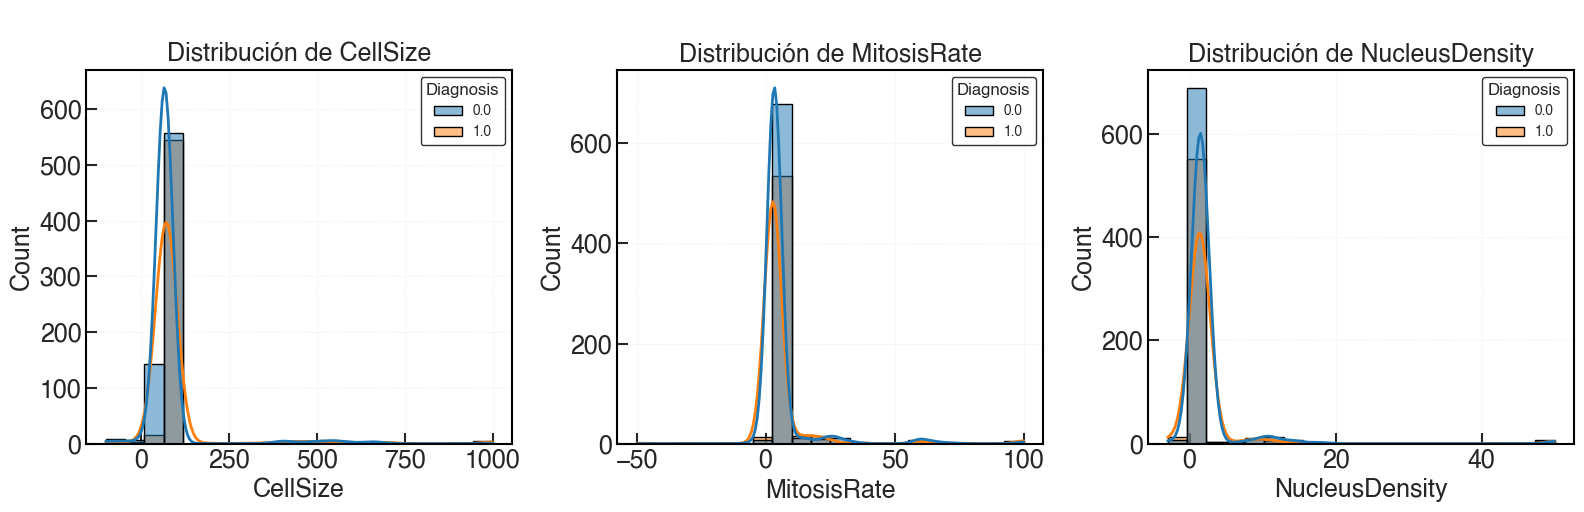

Gráfico guardado en: ./figures/p1/correlation_heatmap_numerical_features_outliers.png


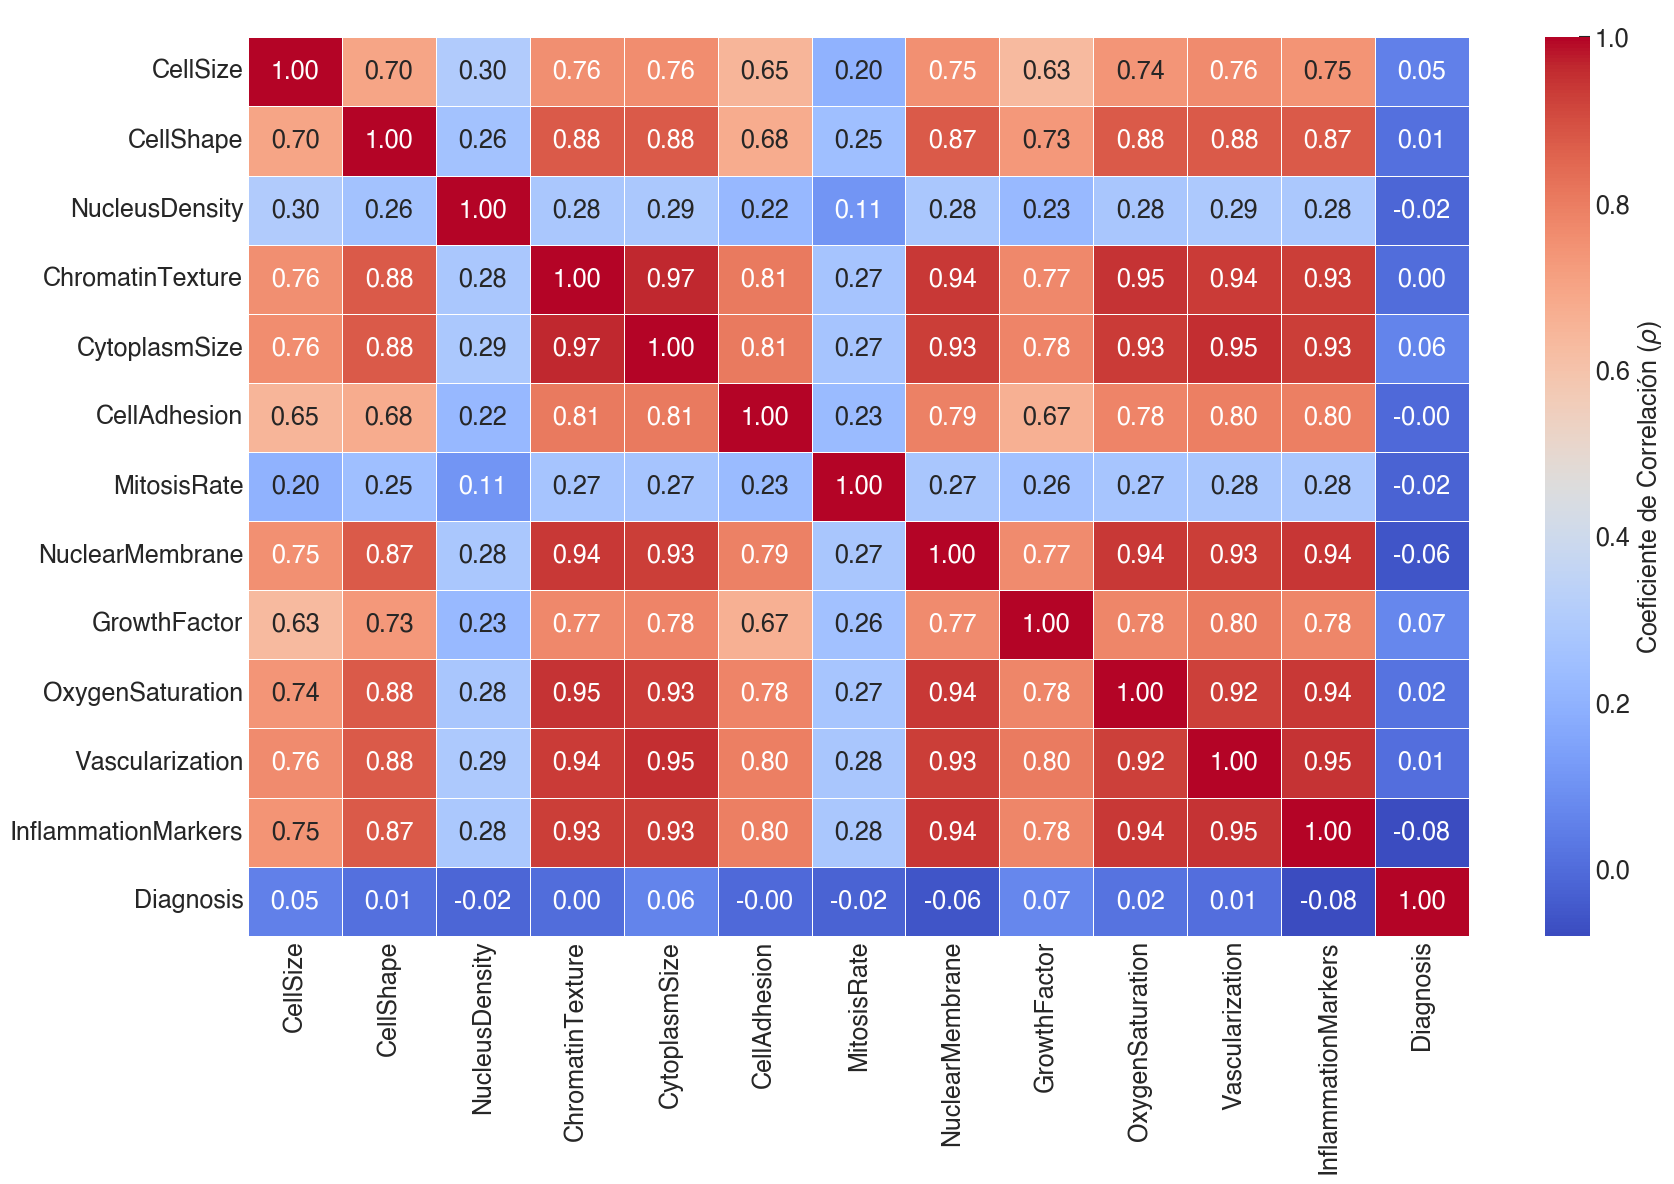

Gráfico guardado en: ./figures/p1/boxplots_outliers_analysis.png


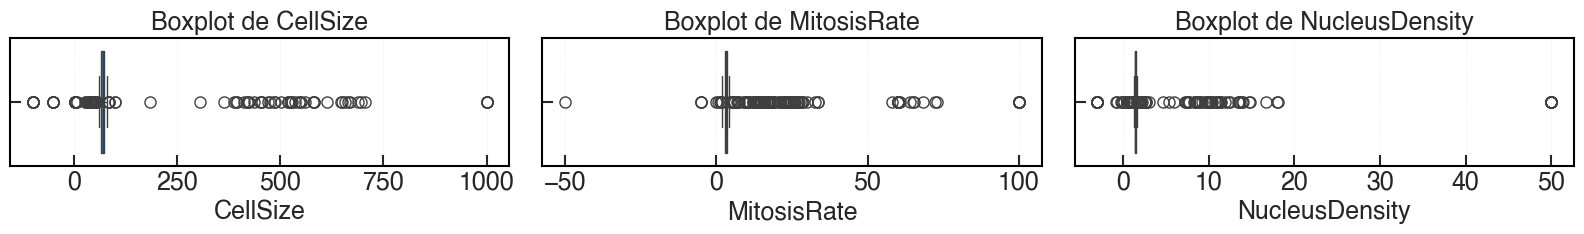

In [103]:


fig_params = {
    "heatmap_params": {
        "title": " ",
        "label_fontsize": 20,
        "title_fontsize": 20,
        "tick_fontsize": 20,
        "cbar_fontsize": 20,
        "annot_fontsize": 20,
        "figsize": (18, 12),
        "filename": "correlation_heatmap_numerical_features_outliers.png"
    },

    "dist_params": {
        "title": " ",
        "filename": "numerical_distributions_outliers.png",
        "features_to_plot":FEATURES_TO_PLOT,
        "tick_fontsize": 22,
        "label_fontsize": 22,
        "title_fontsize": 22,
        "figsize": (16, 5)
    },

    "outlier_params": {
        "filename": "boxplots_outliers_analysis.png",
        "features_to_plot":FEATURES_TO_PLOT,
        "figsize": (20, 5)
    }
}

plot_data_analysis_all_visualizations(
    cell_diagnosis_balanced_for_train_outliers,
    numerical_cols_cell_diagnosis_balanced_train_outliers,
    "Diagnosis",
    FEATURES_TO_PLOT,
    "figures",
    fig_output_dir_p1
);

%% Reemplazo de Outliers

In [104]:
cell_diagnosis_balanced_train, params = replace_outliers_iqr(
    cell_diagnosis_balanced_for_train_outliers, method="winsorize", return_params=True, target_column="Diagnosis"
)
cell_diagnosis_balanced_valid = replace_outliers_iqr(
    cell_diagnosis_balanced_for_valid_outliers, method="winsorize", params=params, target_column="Diagnosis"
)
cell_diagnosis_balanced_test = replace_outliers_iqr(
    cell_diagnosis_balanced_test_outliers, method="winsorize", params=params, target_column="Diagnosis"
)

In [105]:

# Actualizar el loader con los datos procesados
loader_cell_diagnosis.update(
    df_train=cell_diagnosis_balanced_train,
    df_valid=cell_diagnosis_balanced_valid,
    df_test=cell_diagnosis_balanced_test
)

data_dict = {
    'df_train': cell_diagnosis_balanced_train,
    'df_valid': cell_diagnosis_balanced_valid,
    'df_test': cell_diagnosis_balanced_test
}

save_processed_data(
    loader=loader_cell_diagnosis,
    data_dict=data_dict,
    data_dir=data_dir_p1,
    dataset_name="cell_diagnosis_balanced",
    processing_type="processed"
)

In [106]:

loader_cell_diagnosis.read_data(
    train_file="processed/cell_diagnosis_balanced_train.csv",
    valid_file="processed/cell_diagnosis_balanced_valid.csv",
    test_file="processed/cell_diagnosis_balanced_test.csv",
    splitted=True
)
cell_diagnosis_balanced_train, cell_diagnosis_balanced_valid, cell_diagnosis_balanced_test = loader_cell_diagnosis.get_pandas_data(splitted=True)


In [107]:
print_numerical_features_range(cell_diagnosis_balanced_valid)


Feature   Mínimo   Máximo
0              CellSize  57.6812  81.5172
1             CellShape   0.4285   0.5739
2        NucleusDensity   1.2642   1.6212
3      ChromatinTexture  19.3019  24.8079
4         CytoplasmSize  20.4988  36.3413
5          CellAdhesion   0.4116   0.5412
6           MitosisRate   1.8389   4.3878
7       NuclearMembrane   1.8528   2.9358
8          GrowthFactor  50.5599  70.3781
9      OxygenSaturation  76.5477  83.6431
10      Vascularization   4.0558   6.0429
11  InflammationMarkers  28.1420  53.2164
12            Diagnosis   0.0000   1.0000

Gráfico guardado en: figures/numerical_distributions_outliers.png


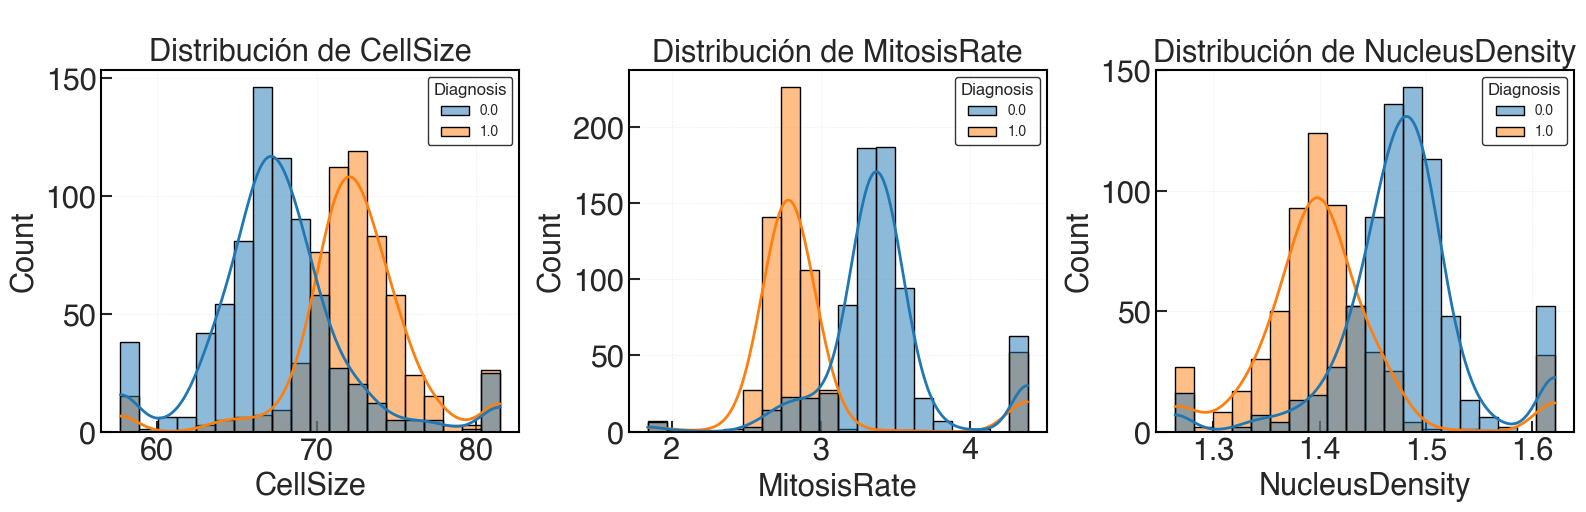

Gráfico guardado en: ./figures/p1/correlation_heatmap_numerical_features_processed.png


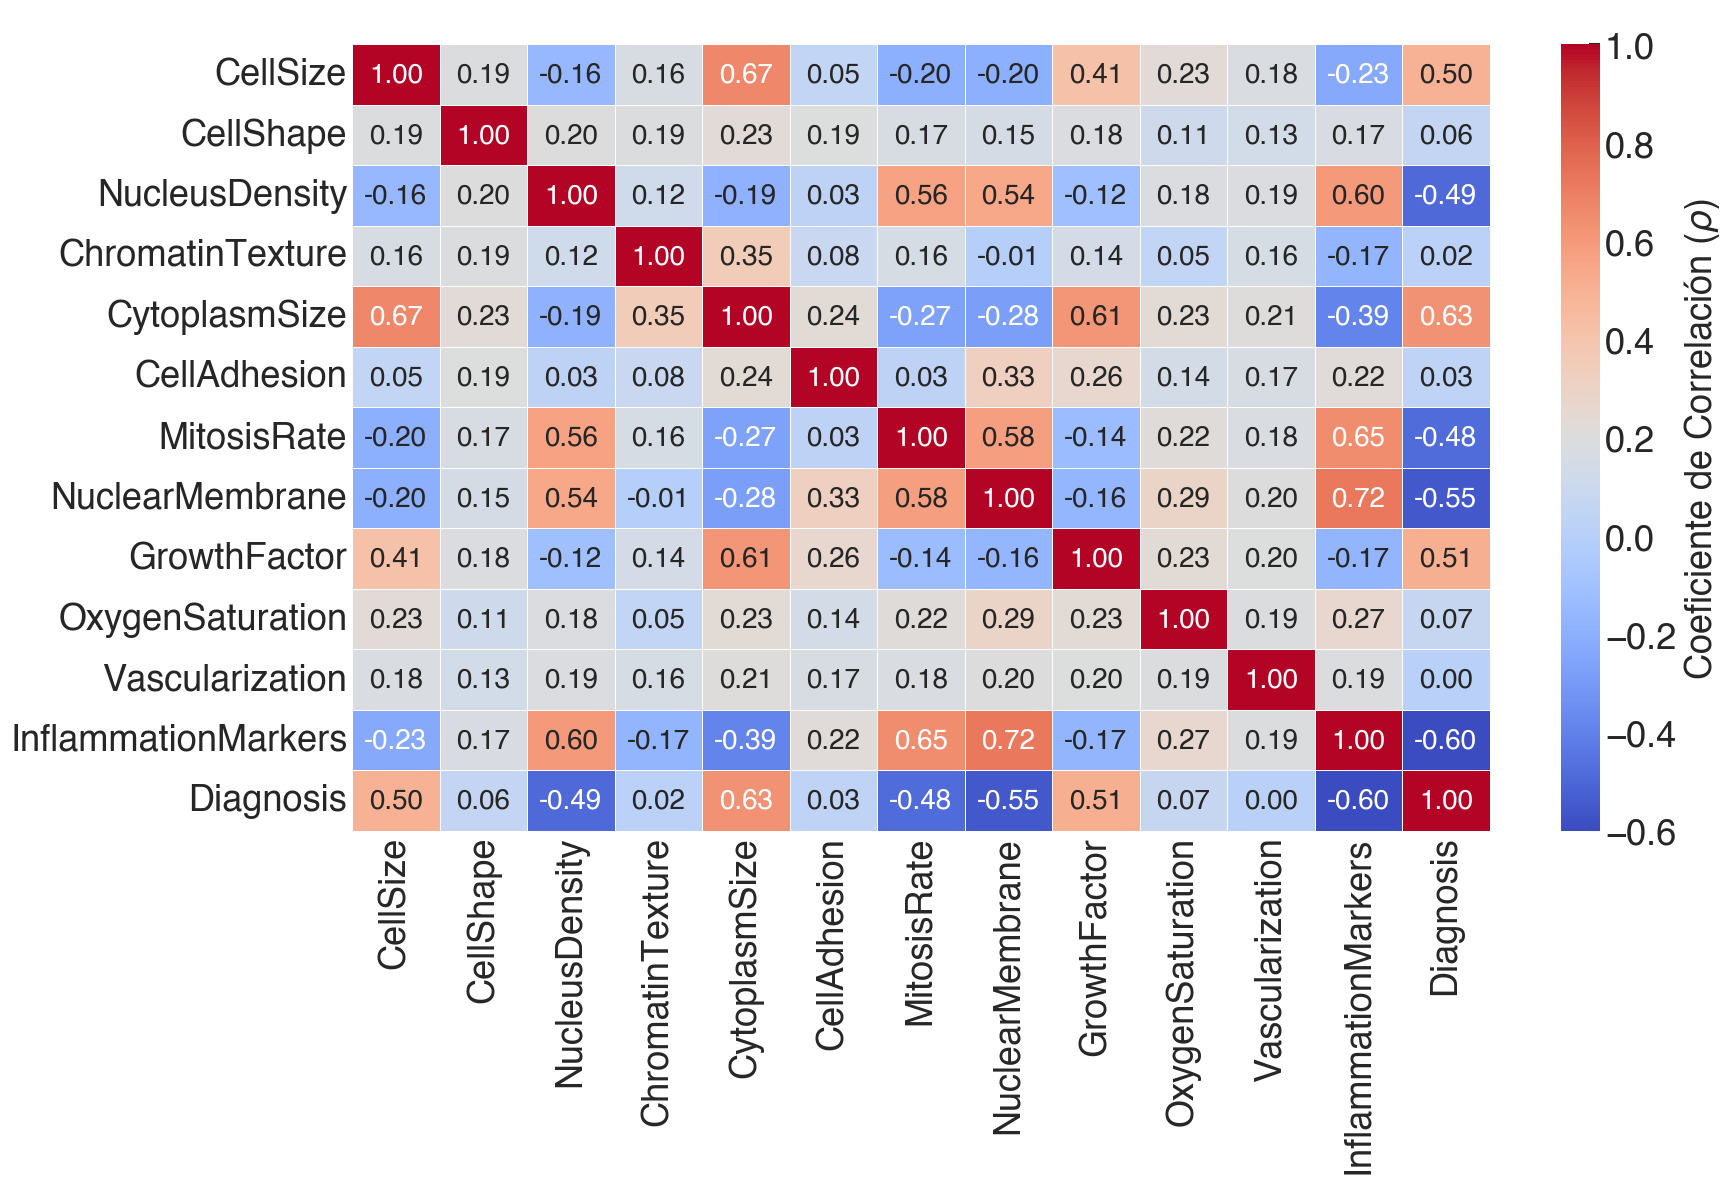

Gráfico guardado en: ./figures/p1/boxplots_outliers_analysis.png


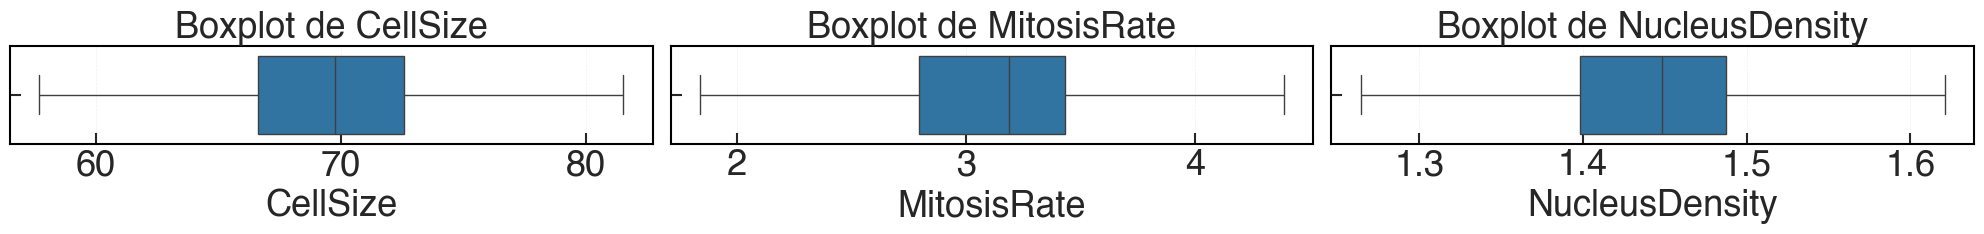

In [108]:

fig_params['heatmap_params']['tick_fontsize'] = 26
fig_params['heatmap_params']['label_fontsize'] = 26
fig_params['heatmap_params']['title_fontsize'] = 26
fig_params['heatmap_params']['cbar_fontsize'] = 26
fig_params['heatmap_params']['annot_fontsize'] = 20
fig_params['heatmap_params']['filename'] = "correlation_heatmap_numerical_features_processed.png"

plot_data_analysis_all_visualizations(
    cell_diagnosis_balanced_train,
    numerical_cols_cell_diagnosis_balanced_train_outliers,
    "Diagnosis",
    FEATURES_TO_PLOT,
    "figures",
    fig_output_dir_p1,
    fig_params
);

# Punto 1.2: Modelado con Regresión Logística - Feature Engineering

In [109]:
transformations = {
    "Nucleus_Cytoplasm_Ratio": lambda d: (d["CellSize"] - d["CytoplasmSize"]) / d["CytoplasmSize"],
    "ProliferationIndex": lambda d: d["GrowthFactor"] * d["MitosisRate"],
    "DensityTextureIndex": lambda d: d["NucleusDensity"] * d["ChromatinTexture"],
}
cell_diagnosis_balanced_train = apply_feature_engineering(cell_diagnosis_balanced_train, transformations, verbose=False)
cell_diagnosis_balanced_valid = apply_feature_engineering(cell_diagnosis_balanced_valid, transformations, verbose=False)
cell_diagnosis_balanced_test = apply_feature_engineering(cell_diagnosis_balanced_test, transformations, verbose=False)

%% Cross Validation para Optimización de Lambda

In [110]:

X_train_cell_diagnosis, y_train_cell_diagnosis, X_valid_cell_diagnosis, y_valid_cell_diagnosis = process_training_data(
    cell_diagnosis_balanced_train,
    cell_diagnosis_balanced_valid
)


In [111]:
lambda_values = np.logspace(-6, 1, 10)

In [112]:

best_lambda, mean_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_balanced_for_cross_validation,
    y=y_train_cell_diagnosis_balanced_for_cross_validation,
    lambda_values=lambda_values,
    categorical_columns=["CellType", "GeneticMutation"],
    preprocess_per_fold=True,
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.2
)


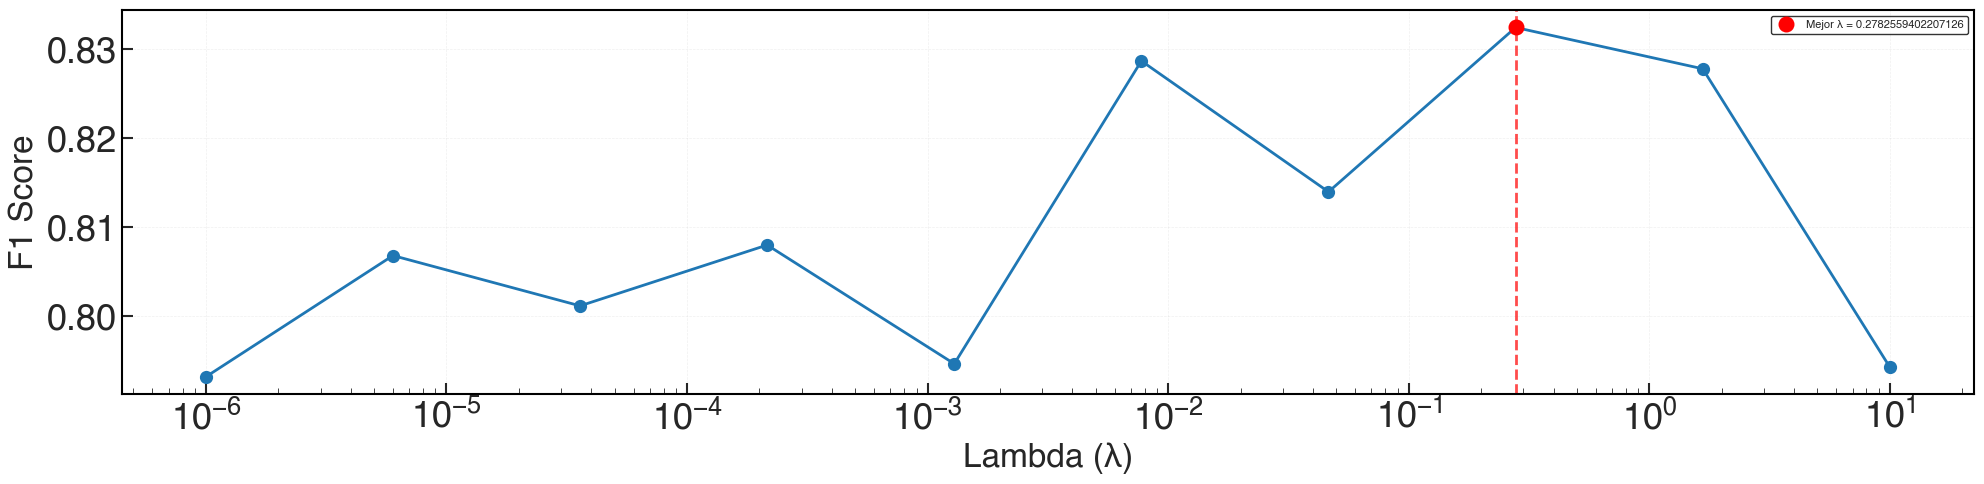

Optimal lambda value: 0.2782559402207126


In [113]:
f1_score.__name__ = "F1 Score"
plot_lambda_tuning(
    lambda_values=lambda_values,
    scores=mean_scores,
    metric_name=f1_score.__name__,
    best_lambda=best_lambda,
    figsize=(20, 5)
)
plt.show()
print(f"Optimal lambda value: {best_lambda}")

%% Entrenamiento Final y Evaluación en Conjunto de Validación

In [114]:

X_train_cell_diagnosis, y_train_cell_diagnosis, X_valid_cell_diagnosis, y_valid_cell_diagnosis = process_training_data(
    cell_diagnosis_balanced_train,
    cell_diagnosis_balanced_valid
)
final_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda
)

In [115]:
final_model = LogisticRegression(final_config)
final_model.fit(X_train_cell_diagnosis, y_train_cell_diagnosis);

Accuracy: 0.9096
Precision: 0.8889
Recall: 0.9231
F1 Score: 0.9057


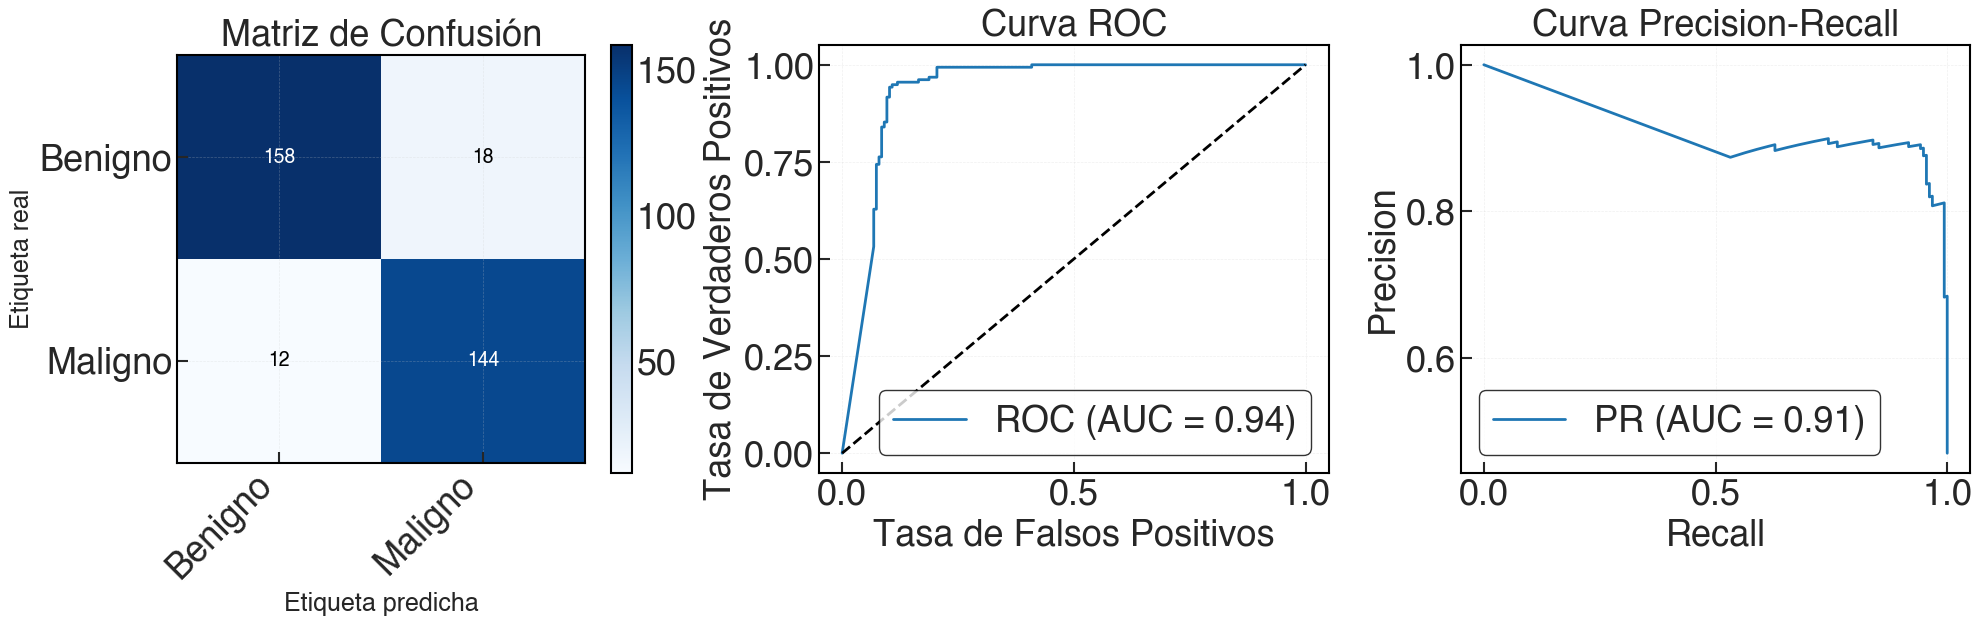

In [116]:
class_names_cell_diagnosis = ["Benigno", "Maligno"]
results = evaluate_model(
    threshold=0.2,
    model=final_model,
    X_test=X_valid_cell_diagnosis,
    y_test=y_valid_cell_diagnosis,
    class_names=class_names_cell_diagnosis,
    save_dir=fig_output_dir_p1,
    figsize=(20, 6),
    base_filename="valid_balanced_logistic_regression"
)

# Punto 1.3: Evaluación en Conjunto de Test Final

In [117]:

X_final_test = cell_diagnosis_balanced_test.drop(columns=["Diagnosis"])
y_final_test = cell_diagnosis_balanced_test["Diagnosis"]

In [118]:
X_final_test = DataLoader.encode_categorical(X_final_test)
X_final_test, y_final_test = X_final_test.to_numpy(), y_final_test.to_numpy()

Accuracy: 0.9243
Precision: 0.9259
Recall: 0.9036
F1 Score: 0.9146


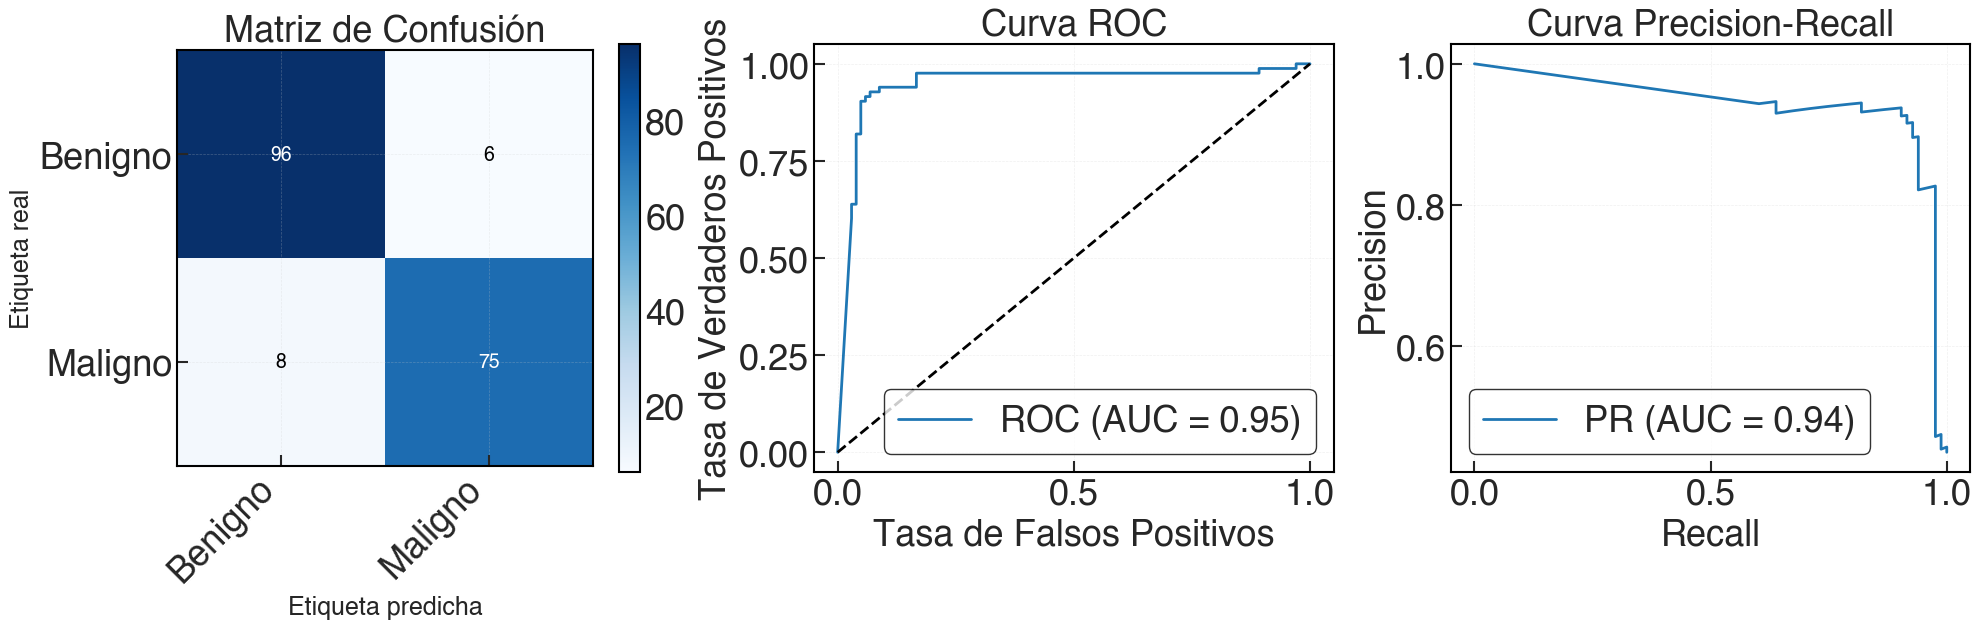

In [119]:

results = evaluate_model(
    model=final_model,
    X_test=X_final_test,
    y_test=y_final_test,
    class_names=class_names_cell_diagnosis,
    save_dir=fig_output_dir_p1,
    figsize=(20, 6),
    base_filename="test_balanced_logistic_regression"
)

# Punto 1.4: Datos Desbalanceados - Carga y Preprocesamiento

In [120]:
config_cell_diagnosis_imbalanced = DatasetConfig(
    data_dir=data_dir_p1,
    target_column="Diagnosis",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)
loader_cell_diagnosis_imbalanced = DataLoader(config_cell_diagnosis_imbalanced)
loader_cell_diagnosis_imbalanced.read_data(
    dev_file="raw/cell_diagnosis_imbalanced_dev.csv",
    test_file="raw/cell_diagnosis_imbalanced_test.csv",
    splitted=False
);

In [121]:

cell_diagnosis_imbalanced_dev_outliers, cell_diagnosis_imbalanced_test_outliers = loader_cell_diagnosis_imbalanced.get_pandas_data(splitted=False)

cell_diagnosis_imbalanced_for_train_outliers, cell_diagnosis_imbalanced_for_valid_outliers = train_valid_split(
    cell_diagnosis_imbalanced_dev_outliers, test_size=0.2, random_state=42
)

In [122]:

analyze_categorical_variables(cell_diagnosis_imbalanced_for_train_outliers, ["CellType", "GeneticMutation", "Diagnosis"]);


Distribución de variables categóricas:

Distribución de CellType:


CellType  Conteo  Porcentaje (%)
0         ???     290           34.81
1    Epthlial     286           34.33
2  Mesnchymal     257           30.85


Distribución de GeneticMutation:


GeneticMutation  Conteo  Porcentaje (%)
0          Presnt     509           52.21
1           Absnt     466           47.79


Distribución de Diagnosis:


Diagnosis  Conteo  Porcentaje (%)
0        0.0     732           75.08
1        1.0     243           24.92

In [123]:
analyze_null_values(
    [cell_diagnosis_imbalanced_for_train_outliers, cell_diagnosis_imbalanced_test_outliers],
    ["conjunto de entrenamiento imbalanceado", "conjunto de prueba imbalanceado"]
);

Valores nulos en conjunto de entrenamiento imbalanceado:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                187           19.18
1             CellShape                184           18.87
2        NucleusDensity                161           16.51
3      ChromatinTexture                176           18.05
4         CytoplasmSize                208           21.33
5          CellAdhesion                174           17.85
6           MitosisRate                186           19.08
7       NuclearMembrane                173           17.74
8          GrowthFactor                180           18.46
9      OxygenSaturation                175           17.95
10      Vascularization                192           19.69
11  InflammationMarkers                169           17.33
12            Diagnosis                  0            0.00
13             CellType                142           14.56
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo       897            92.0
1           Muestras sin valores nulos        78             8.0
2                    Total de muestras       975           100.0



Valores nulos en conjunto de prueba imbalanceado:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                 25           18.38
1             CellShape                 31           22.79
2        NucleusDensity                 28           20.59
3      ChromatinTexture                 25           18.38
4         CytoplasmSize                 23           16.91
5          CellAdhesion                 19           13.97
6           MitosisRate                 31           22.79
7       NuclearMembrane                 16           11.76
8          GrowthFactor                 32           23.53
9      OxygenSaturation                 25           18.38
10      Vascularization                 31           22.79
11  InflammationMarkers                 28           20.59
12            Diagnosis                  0            0.00
13             CellType                 21           15.44
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo       127           93.38
1           Muestras sin valores nulos         9            6.62
2                    Total de muestras       136          100.00

In [124]:

X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation = cell_diagnosis_imbalanced_for_train_outliers.drop(columns=["Diagnosis"])

y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation = cell_diagnosis_imbalanced_for_train_outliers["Diagnosis"].to_numpy()


In [125]:

cell_diagnosis_imbalanced_for_train_outliers, cell_diagnosis_imbalanced_for_valid_outliers, cell_diagnosis_imbalanced_test_outliers = impute_missing_values(
    cell_diagnosis_imbalanced_for_train_outliers,
    cell_diagnosis_imbalanced_for_valid_outliers,
    cell_diagnosis_imbalanced_test_outliers,
    knn_neighbors=8,
    knn_weights="distance"
)

loader_cell_diagnosis_imbalanced.update(
    df_train=cell_diagnosis_imbalanced_for_train_outliers,
    df_valid=cell_diagnosis_imbalanced_for_valid_outliers,
    df_test=cell_diagnosis_imbalanced_test_outliers
);

Missing values before imputation:
Train: 2307 missing values
Valid: 605 missing values
Test: 335 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


In [126]:
# Guardar los datos preprocesados usando la función save_processed_data


data_dict = {
    'df_train': cell_diagnosis_imbalanced_for_train_outliers,
    'df_valid': cell_diagnosis_imbalanced_for_valid_outliers,
    'df_test': cell_diagnosis_imbalanced_test_outliers
}

save_processed_data(
    loader=loader_cell_diagnosis_imbalanced,
    data_dict=data_dict,
    data_dir=data_dir_p1,
    dataset_name="cell_diagnosis_imbalanced",
    processing_type="preprocessed"
)


In [127]:

loader_cell_diagnosis_imbalanced.read_data(
    train_file="preprocessed/cell_diagnosis_imbalanced_train.csv",
    valid_file="preprocessed/cell_diagnosis_imbalanced_valid.csv",
    test_file="preprocessed/cell_diagnosis_imbalanced_test.csv",
    splitted=True
);

In [128]:

print_numerical_features_range(cell_diagnosis_imbalanced_for_valid_outliers)

Feature    Mínimo    Máximo
0              CellSize -100.0000  613.1569
1             CellShape   -0.3719    4.5236
2        NucleusDensity   -3.0000   50.0000
3      ChromatinTexture   18.9533  204.6890
4         CytoplasmSize   11.2851  299.3506
5          CellAdhesion   -3.1463    4.0465
6           MitosisRate   -5.0000   65.3126
7       NuclearMembrane   -1.1124   24.8718
8          GrowthFactor  -10.0000  438.0238
9      OxygenSaturation  -10.0000  612.2901
10      Vascularization    2.4756   54.5124
11  InflammationMarkers   17.6405  415.7123
12            Diagnosis    0.0000    1.0000

Gráfico guardado en: figures/numerical_distributions_outliers.png


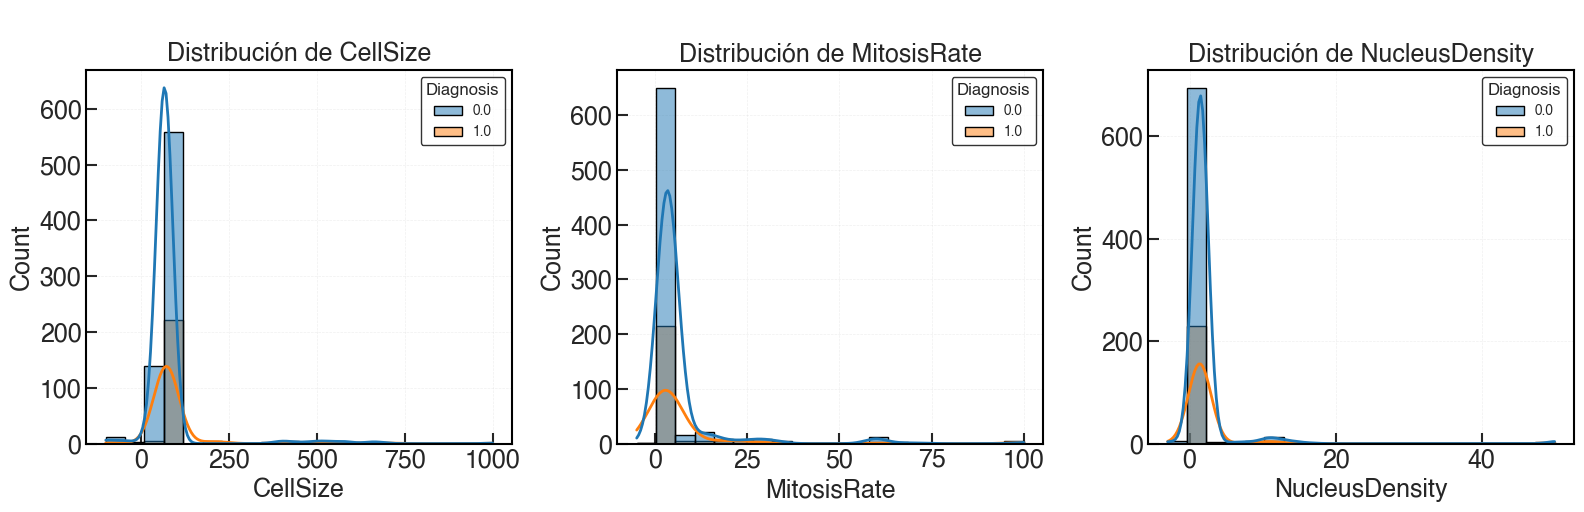

Gráfico guardado en: ./figures/p1/correlation_heatmap_numerical_features_outliers.png


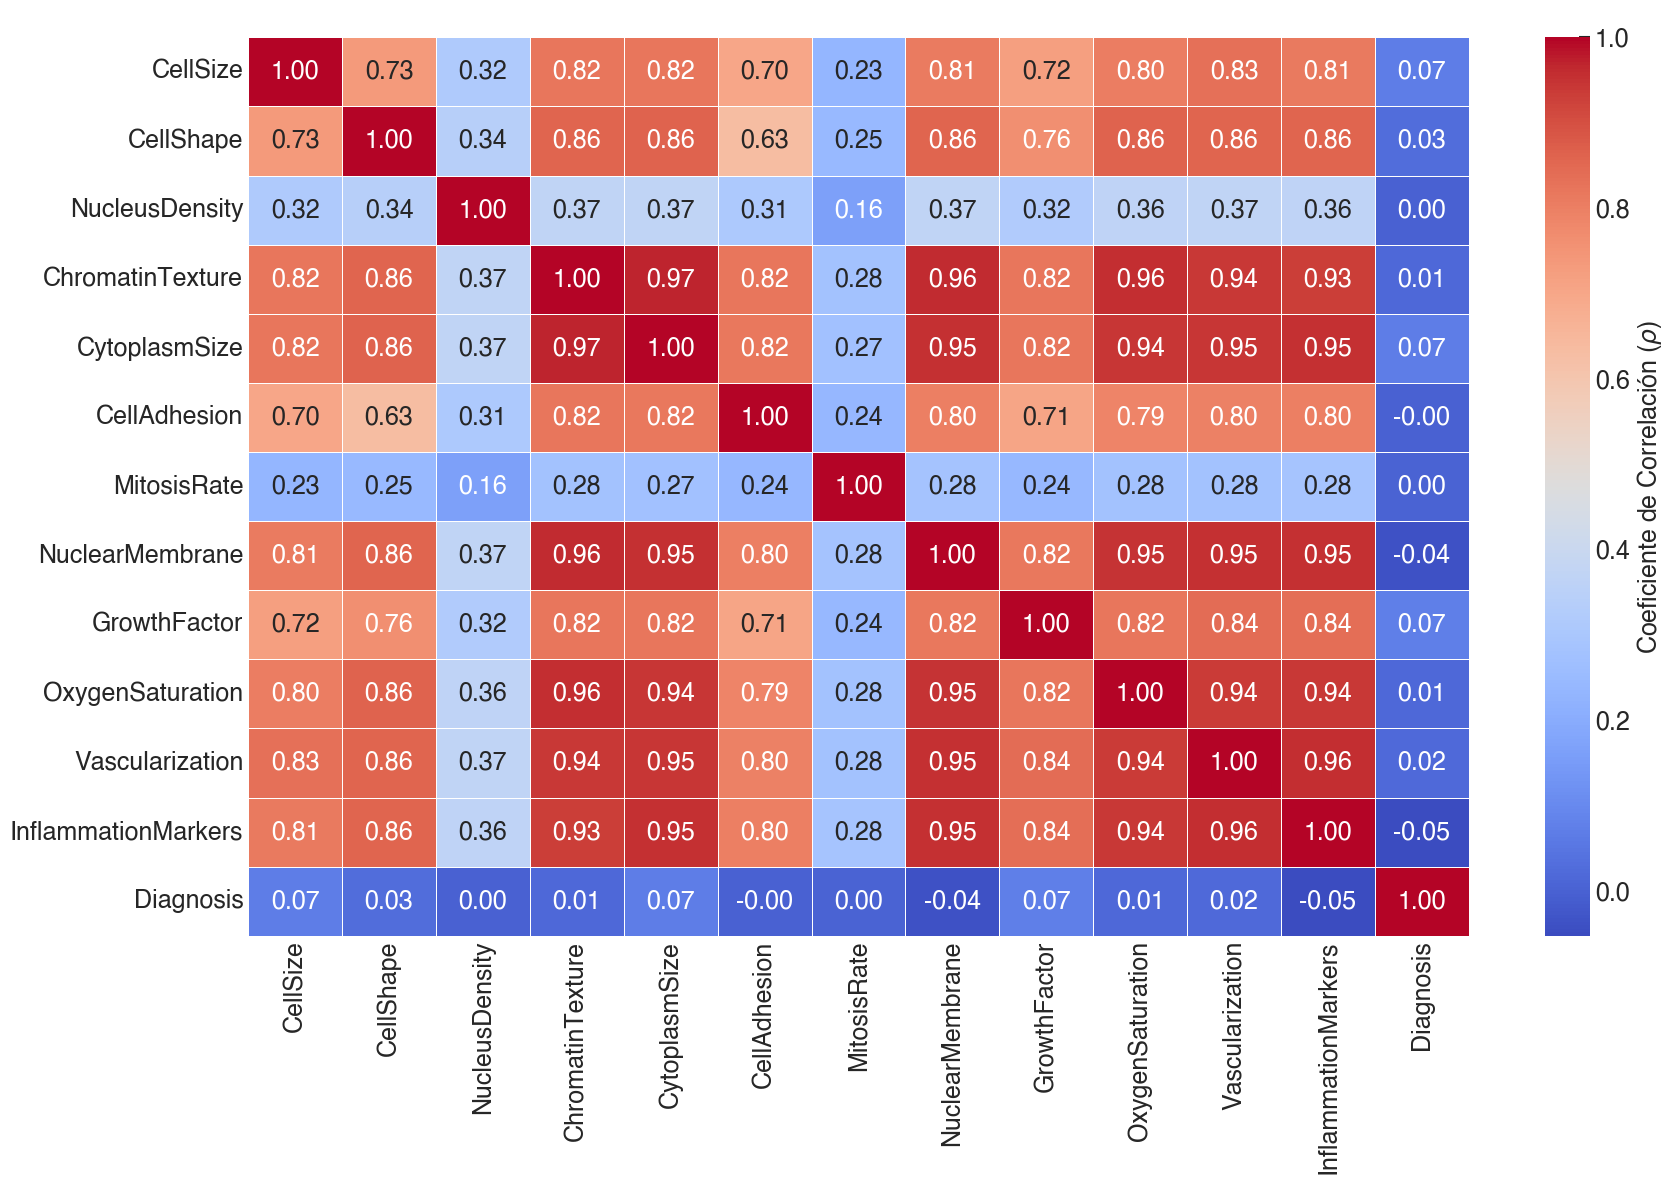

Gráfico guardado en: ./figures/p1/boxplots_outliers_analysis.png


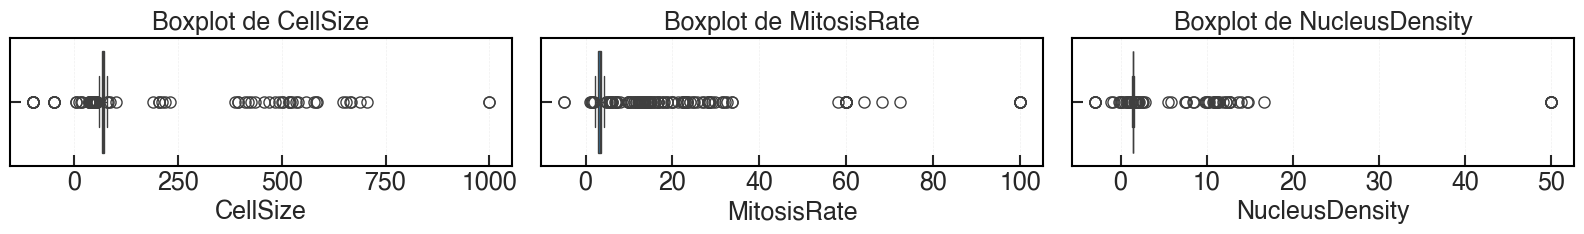

(<Figure size 1600x500 with 3 Axes>,
 <Figure size 1800x1200 with 2 Axes>,
 [<Figure size 1600x250 with 3 Axes>])

In [129]:
plot_data_analysis_all_visualizations(
    cell_diagnosis_imbalanced_for_train_outliers,
    numerical_cols_cell_diagnosis_balanced_train_outliers,
    "Diagnosis",
    FEATURES_TO_PLOT,
    "figures",
    fig_output_dir_p1
)


In [130]:

cell_diagnosis_imbalanced_for_train, params = replace_outliers_iqr(
    cell_diagnosis_imbalanced_for_train_outliers, method="winsorize", return_params=True, target_column="Diagnosis"
)
cell_diagnosis_imbalanced_for_valid = replace_outliers_iqr(
    cell_diagnosis_imbalanced_for_valid_outliers, method="winsorize", params=params, target_column="Diagnosis"
)
cell_diagnosis_imbalanced_test = replace_outliers_iqr(
    cell_diagnosis_imbalanced_test_outliers, method="winsorize", params=params, target_column="Diagnosis"
)


In [131]:
data_dict = {
    'df_train': cell_diagnosis_imbalanced_for_train,
    'df_valid': cell_diagnosis_imbalanced_for_valid,
    'df_test': cell_diagnosis_imbalanced_test
}

save_processed_data(
    loader=loader_cell_diagnosis_imbalanced,
    data_dict=data_dict,
    data_dir=data_dir_p1,
    dataset_name="cell_diagnosis_imbalanced",
    processing_type="processed"
)

In [132]:

loader_cell_diagnosis_imbalanced.read_data(
    train_file="processed/cell_diagnosis_imbalanced_train.csv",
    valid_file="processed/cell_diagnosis_imbalanced_valid.csv",
    test_file="processed/cell_diagnosis_imbalanced_test.csv",
    splitted=True
);

Gráfico guardado en: figures/numerical_distributions_outliers.png


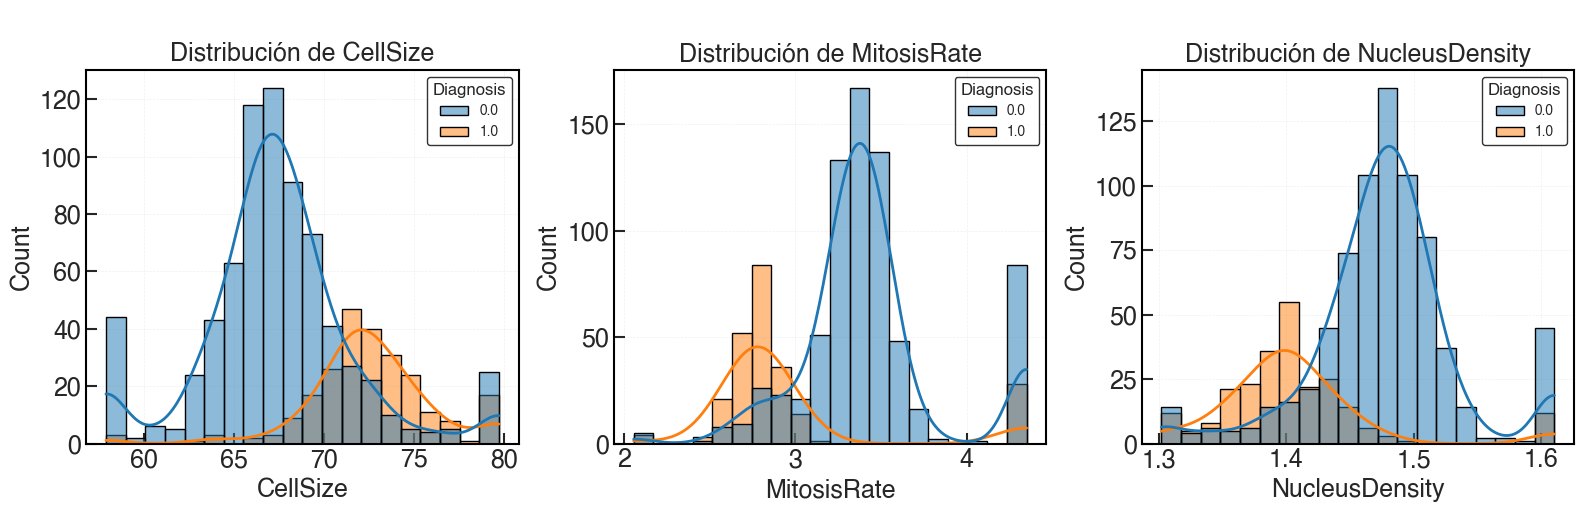

Gráfico guardado en: ./figures/p1/correlation_heatmap_numerical_features_outliers.png


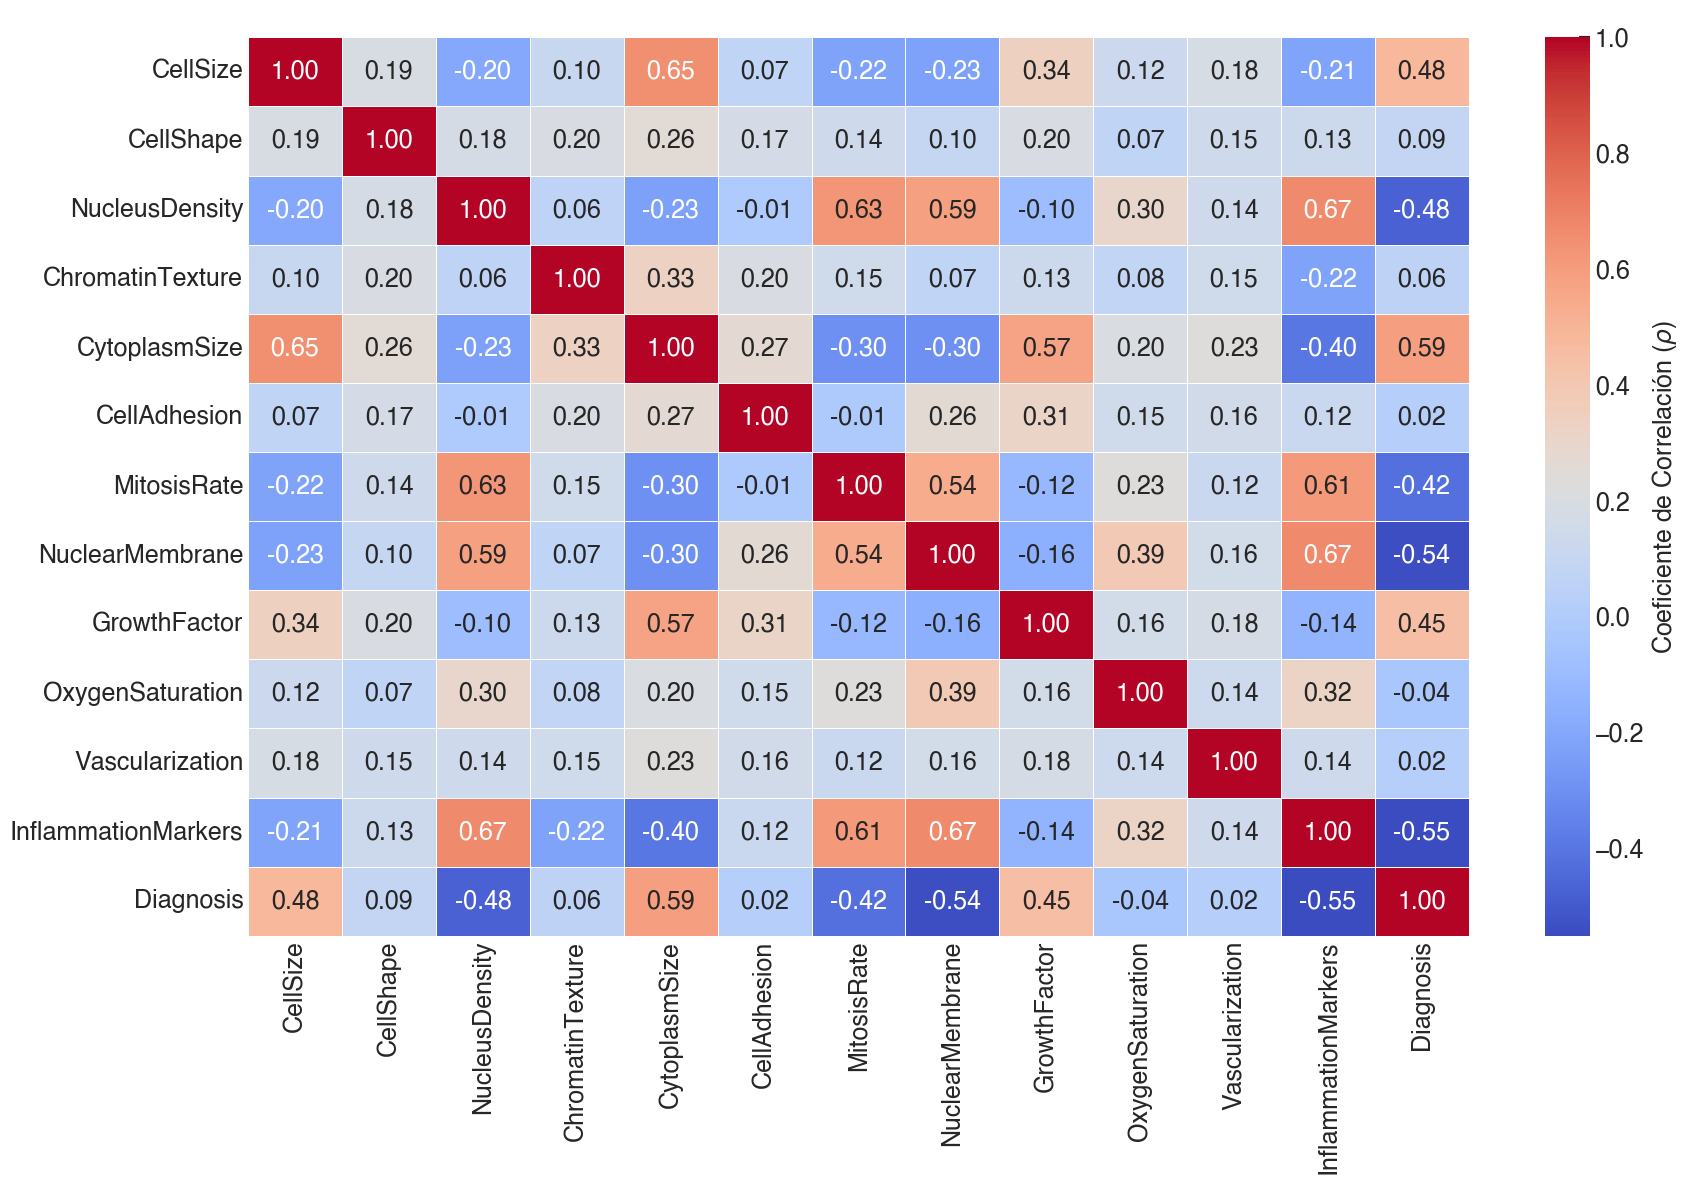

Gráfico guardado en: ./figures/p1/boxplots_outliers_analysis.png


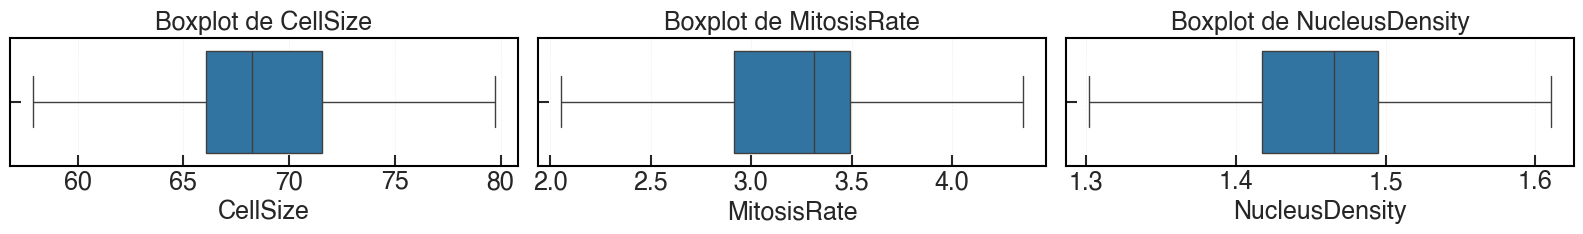

(<Figure size 1600x500 with 3 Axes>,
 <Figure size 1800x1200 with 2 Axes>,
 [<Figure size 1600x250 with 3 Axes>])

In [133]:

plot_data_analysis_all_visualizations(
    cell_diagnosis_imbalanced_for_train,
    numerical_cols_cell_diagnosis_balanced_train_outliers,
    "Diagnosis",
    FEATURES_TO_PLOT,
    "figures",
    fig_output_dir_p1
)


In [134]:

# Ejemplo de uso
X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced, X_val_cell_diagnosis_imbalanced, y_val_cell_diagnosis_imbalanced = process_training_data(
    cell_diagnosis_imbalanced_for_train,
    cell_diagnosis_imbalanced_for_valid
)


In [135]:
X_test_cell_diagnosis_imbalanced, y_test_cell_diagnosis_imbalanced = loader_cell_diagnosis_imbalanced.get_processed_test_data(
    return_numpy=True,
    encode_categorical=True,
    normalize=False
)


In [136]:
class_names = ["Malignant","Benign" ]

In [137]:
all_models = {}

In [138]:
# --- Validación cruzada sin rebalancing para elegir lambda ---
# Se asume que ya se tiene definido un rango de valores para lambda_values y la función f1_score.
best_lambda_nr, cv_scores_nr = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    lambda_values=lambda_values,       # Por ejemplo, un np.concatenate de logspace
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.2,
    categorical_columns=["CellType", "GeneticMutation"],
    preprocess_per_fold=True,
    aggregate_predictions=True,         # Calcula la métrica global al final
    resampler=None                      # No aplica re-muestreo en este caso
)

print(f"Optimal lambda for non-rebalancing: {best_lambda_nr}")

# --- Configurar la regresión logística con el lambda óptimo obtenido ---

lr_config_no_rebalancing = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda_nr,
    random_state=42,
    verbose=False
)


# --- Entrenamiento del modelo sin aplicar ninguna técnica de rebalancing ---
model_no_rebalancing = LogisticRegression(lr_config_no_rebalancing)
model_no_rebalancing.fit(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)

# --- Evaluación del modelo en el conjunto de validación ---
metrics_no_rebalancing = evaluate_model(
    model=model_no_rebalancing,
    X_test=X_val_cell_diagnosis_imbalanced,
    y_test=y_val_cell_diagnosis_imbalanced, 
    class_names=class_names, 
    show_plots=False,
    threshold=0.2,
    figsize=(10, 6),
    print_metrics=False
)

all_models["No rebalancing"] = {
    "model": model_no_rebalancing,
    "metrics": metrics_no_rebalancing
}


Optimal lambda for non-rebalancing: 1.6681005372000592


In [139]:
# Primero, definimos la estrategia de undersampling:
undersampler = RandomUnderSampler(RebalancingConfig(random_state=42, sampling_strategy=0.5))


# Realizar validación cruzada aplicando undersampling en cada fold
best_lambda_under, cv_scores_under = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    lambda_values=lambda_values,
    metric_fn=f1_score,       
    categorical_columns=["CellType", "GeneticMutation"],
    k_folds=5,
    verbose=False,
    threshold=0.2,
    aggregate_predictions=True,   # Calcula la métrica global al final
    resampler=undersampler         # Aplica undersampling en cada fold
)

print(f"\nOptimal lambda for undersampling: {best_lambda_under}")



Optimal lambda for undersampling: 0.04641588833612782


In [140]:

# Crear la configuración final del modelo con el lambda óptimo obtenido
lr_config_under = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda_under,
    random_state=42,
    verbose=False
)

# Re-aplicar undersampling al conjunto de entrenamiento final (para consistencia)
X_train_under, y_train_under = undersampler.fit_resample(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)

# Entrenar el modelo final con la configuración optimizada
model_undersampling = LogisticRegression(lr_config_under)
model_undersampling.fit(X_train_under, y_train_under)

# Evaluar el modelo en el conjunto de validación
metrics_undersampling = evaluate_model(
    threshold=0.2,
    model=model_undersampling, 
    X_test=X_val_cell_diagnosis_imbalanced, 
    y_test=y_val_cell_diagnosis_imbalanced, 
    class_names=class_names, 
    show_plots=False,
    figsize=(10, 6), 
    print_metrics=False
)

# Agregar el modelo y sus métricas al diccionario de modelos evaluados
all_models["Undersampling"] = {
    "model": model_undersampling,
    "metrics": metrics_undersampling
}


In [141]:
# --- Definir el oversampler y re-muestrear el conjunto de entrenamiento original ---
oversampler = RandomOverSampler(RebalancingConfig(random_state=42))



# --- Realizar validación cruzada utilizando el oversampler ---
# Se utiliza el parámetro "resampler" para que en cada fold se aplique la técnica de re-muestreo.
optimal_lambda, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,             # Se utiliza el conjunto original; el oversampler se aplica internamente
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    categorical_columns=["CellType", "GeneticMutation"],
    lambda_values=lambda_values,
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.2,
    resampler=oversampler  # Aplica oversampling en cada fold
)

print(f"\nOptimal lambda: {optimal_lambda}")

# --- Configurar el modelo con el lambda óptimo ---
lr_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=optimal_lambda,
    random_state=42,
    verbose=False
)


# --- Re-aplicar oversampling al conjunto de entrenamiento para el entrenamiento final ---
X_train_over, y_train_over = oversampler.fit_resample(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)

# --- Entrenar el modelo final con la configuración optimizada ---
model_oversampling = LogisticRegression(lr_config)
model_oversampling.fit(X_train_over, y_train_over)

# --- Evaluar el modelo final en el conjunto de validación ---
metrics_oversampling = evaluate_model(
    model=model_oversampling,
    X_test=X_val_cell_diagnosis_imbalanced,
    y_test=y_val_cell_diagnosis_imbalanced,
    class_names=class_names,
    show_plots=False,
    threshold=0.2,
    figsize=(10, 6),
    print_metrics=False
)

all_models["Oversampling duplicate"] = {
    "model": model_oversampling,
    "metrics": metrics_oversampling
}



Optimal lambda: 10.0


In [142]:

smote = SMOTE(SMOTEConfig(random_state=42, k_neighbors=5))

optimal_lambda, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,             # Se utiliza el conjunto original; el oversampler se aplica internamente
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    lambda_values=lambda_values,
    categorical_columns=["CellType", "GeneticMutation"],
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.2,
    resampler=smote  # Aplica oversampling en cada fold
)

print(f"\nOptimal lambda: {optimal_lambda}")

# --- Configurar el modelo con el lambda óptimo ---
lr_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=optimal_lambda,
    random_state=42,
    verbose=False
)


X_train_smote, y_train_smote = smote.fit_resample(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)
model_smote = LogisticRegression(lr_config)
model_smote.fit(X_train_smote, y_train_smote);

metrics_smote = evaluate_model(
    model_smote, X_val_cell_diagnosis_imbalanced, y_val_cell_diagnosis_imbalanced, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)
all_models["Oversampling SMOTE"] = {
    "model": model_smote,
    "metrics": metrics_smote
}


Optimal lambda: 1.6681005372000592


In [143]:
print("\n===== Training model with Cost reweighting =====")
# Calcula los pesos de clase (por ejemplo, usando una función calculate_class_weights que ya tengas)
class_weights = calculate_class_weights(y_train_cell_diagnosis_imbalanced)
print(f"Class weights: {class_weights}")


# Realizar validación cruzada cost-sensitive para elegir el mejor lambda:
# Se pasa el parámetro resampler si se desea aplicar alguna técnica de re-muestreo en cada fold; de lo contrario, se puede dejar como None.
best_lambda_cost_rw, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    lambda_values=lambda_values,
    categorical_columns=["CellType", "GeneticMutation"],
    metric_fn=f1_score,          
    k_folds=5,
    verbose=False,
    threshold=0.2,
    apply_class_reweighting=True,
    aggregate_predictions=True,   
    resampler=None                
)

print(f"\nOptimal lambda found: {best_lambda_cost_rw}")

# Crear la configuración del modelo cost-sensitive con el lambda óptimo obtenido
cost_sensitive_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=3000,
    tol=1e-4,
    lambda_reg=best_lambda_cost_rw,
    random_state=42,
    verbose=False,
    class_weight=class_weights
)
model_cost = LogisticRegression(cost_sensitive_config)
model_cost.fit(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)

# Evaluar el modelo entrenado en el conjunto de validación
metrics_cost = evaluate_model(
    model=model_cost,
    X_test=X_val_cell_diagnosis_imbalanced,
    y_test=y_val_cell_diagnosis_imbalanced,
    class_names=class_names,
    show_plots=False,
    threshold=0.2,
    figsize=(10, 6),
    print_metrics=False
)

all_models["Cost re-weighting"] = {
    "model": model_cost,
    "metrics": metrics_cost
}



===== Training model with Cost reweighting =====
Class weights: {np.float64(0.0): 1.0, np.float64(1.0): np.float64(3.0123456790123457)}

Optimal lambda found: 10.0


Evaluando modelos en el conjunto de validation
Evaluando No rebalancing
Evaluando Undersampling
Evaluando Oversampling duplicate
Evaluando Oversampling SMOTE
Evaluando Cost re-weighting
Gráfico guardado en: ./figures/p1/validation_combined_curves_comparison.png


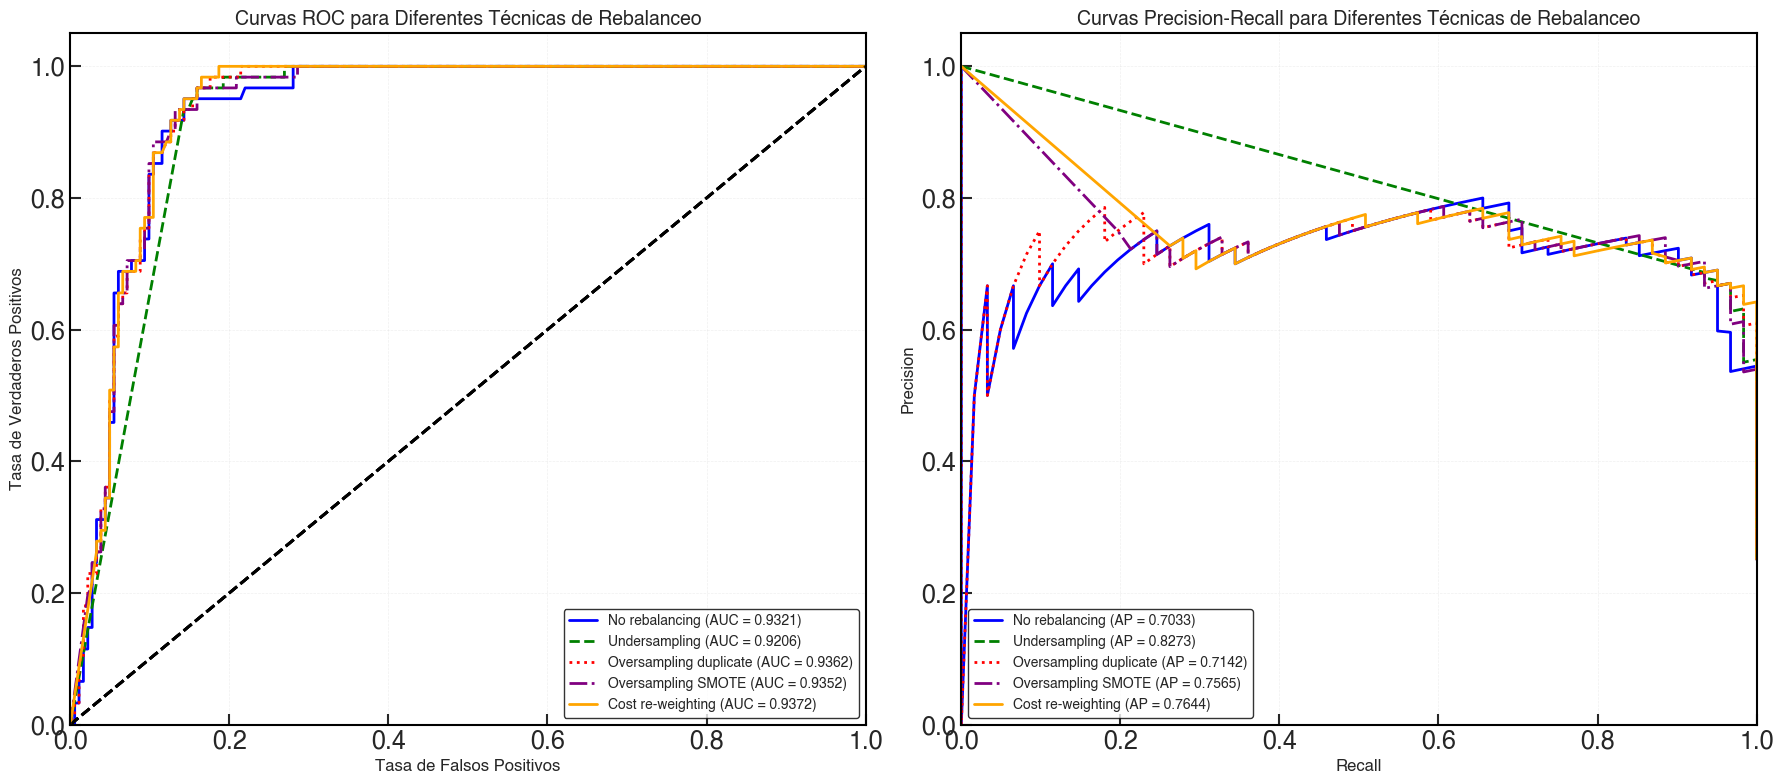

In [144]:
# Antes de ejecutar evaluate_all_models, necesitamos asegurar que y_val_cell_diagnosis_imbalanced sea un array NumPy
y_val_cell_diagnosis_imbalanced = np.asarray(y_val_cell_diagnosis_imbalanced)

val_metrics_df, val_metrics = evaluate_all_models(
    all_models, 
    X_val_cell_diagnosis_imbalanced, 
    y_val_cell_diagnosis_imbalanced, 
    class_names, 
    fig_output_dir_p1,
    prefix="validation",
    subplots=True,
    show_plot=True,
    individual_plots=False
)

Evaluando modelos en el conjunto de test
Evaluando No rebalancing
Evaluando Undersampling
Evaluando Oversampling duplicate
Evaluando Oversampling SMOTE
Evaluando Cost re-weighting
Gráfico guardado en: ./figures/p1/test_combined_curves_comparison.png


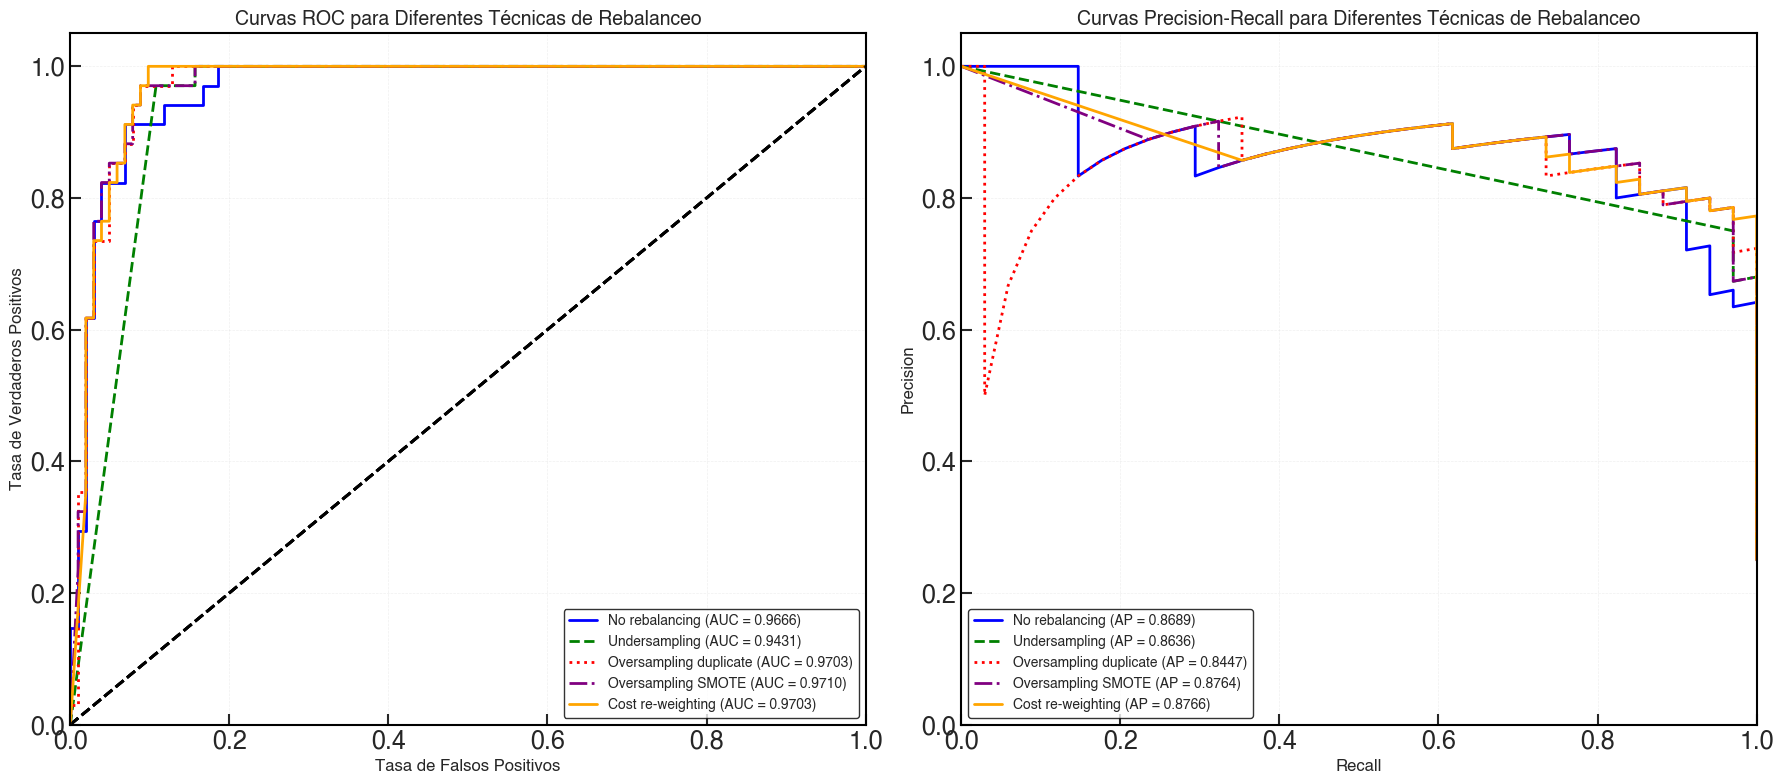

In [145]:
test_metrics_df, test_metrics = evaluate_all_models(
    all_models, 
    X_test_cell_diagnosis_imbalanced, 
    y_test_cell_diagnosis_imbalanced, 
    class_names, 
    fig_output_dir_p1,
    subplots=True,
    prefix="test",
    show_plot=True,
    individual_plots=False
)

In [146]:
from utils.utils import format_metrics_table
val_metrics_display = format_metrics_table(val_metrics_df, "Validation Metrics Summary")
test_metrics_display = format_metrics_table(test_metrics_df, "Test Metrics Summary")


===== Validation Metrics Summary =====


Model Accuracy Precision  Recall F-Score AUC-ROC  AUC-PR
0          No rebalancing   0.8601    0.7288  0.7049  0.7167  0.9321  0.7033
1           Undersampling   0.3457    0.2773  1.0000  0.4342  0.9206  0.8273
2  Oversampling duplicate   0.8848    0.7324  0.8525  0.7879  0.9362  0.7142
3      Oversampling SMOTE   0.8889    0.7361  0.8689  0.7970  0.9352  0.7565
4       Cost re-weighting   0.8724    0.7344  0.7705  0.7520  0.9372  0.7644


===== Test Metrics Summary =====


Model Accuracy Precision  Recall F-Score AUC-ROC  AUC-PR
0          No rebalancing   0.8971    0.8846  0.6765  0.7667  0.9666  0.8689
1           Undersampling   0.3235    0.2698  1.0000  0.4250  0.9431  0.8636
2  Oversampling duplicate   0.9191    0.8286  0.8529  0.8406  0.9703  0.8447
3      Oversampling SMOTE   0.9118    0.8056  0.8529  0.8286  0.9710  0.8764
4       Cost re-weighting   0.9118    0.8438  0.7941  0.8182  0.9703  0.8766

# Punto 1.6


El mejor modelo es cost reweighting

In [147]:


best_lambda_cost_rw, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    lambda_values=lambda_values,
    categorical_columns=["CellType", "GeneticMutation"],
    metric_fn=f1_score,          
    k_folds=5,
    verbose=False,
    apply_class_reweighting=True,
    threshold=0.2,
    aggregate_predictions=True       
)

print(f"\nOptimal lambda found: {best_lambda_cost_rw}")



Optimal lambda found: 10.0


In [148]:


cell_diagnosis_imbalanced_dev_outliers = impute_missing_values(
    cell_diagnosis_imbalanced_dev_outliers,
    knn_neighbors=5,
    knn_weights="distance"
)


cell_diagnosis_imbalanced_dev_outliers = replace_outliers_iqr(
    cell_diagnosis_imbalanced_dev_outliers,
    method="iqr",
    target_column="Diagnosis"
)



X_train_cell_diagnosis_imbalanced_dev_outliers = cell_diagnosis_imbalanced_dev_outliers.drop(columns=["Diagnosis"])


# Encoder la variable diagnosis
X_train_cell_diagnosis_imbalanced_dev_outliers = DataLoader.encode_categorical(X_train_cell_diagnosis_imbalanced_dev_outliers).to_numpy()
y_train_cell_diagnosis_imbalanced_dev_outliers = cell_diagnosis_imbalanced_dev_outliers["Diagnosis"].to_numpy()



# Crear la configuración del modelo cost-sensitive con el lambda óptimo obtenido
cost_sensitive_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=3000,
    tol=1e-4,
    lambda_reg=best_lambda_cost_rw,
    random_state=42,
    verbose=False,
    class_weight=class_weights
)
model_cost = LogisticRegression(cost_sensitive_config)
model_cost.fit(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced);


Missing values before imputation:
Train: 2912 missing values

Missing values after imputation:
Train: 0 missing values


Accuracy: 0.9118
Precision: 0.8235
Recall: 0.8235
F1 Score: 0.8235


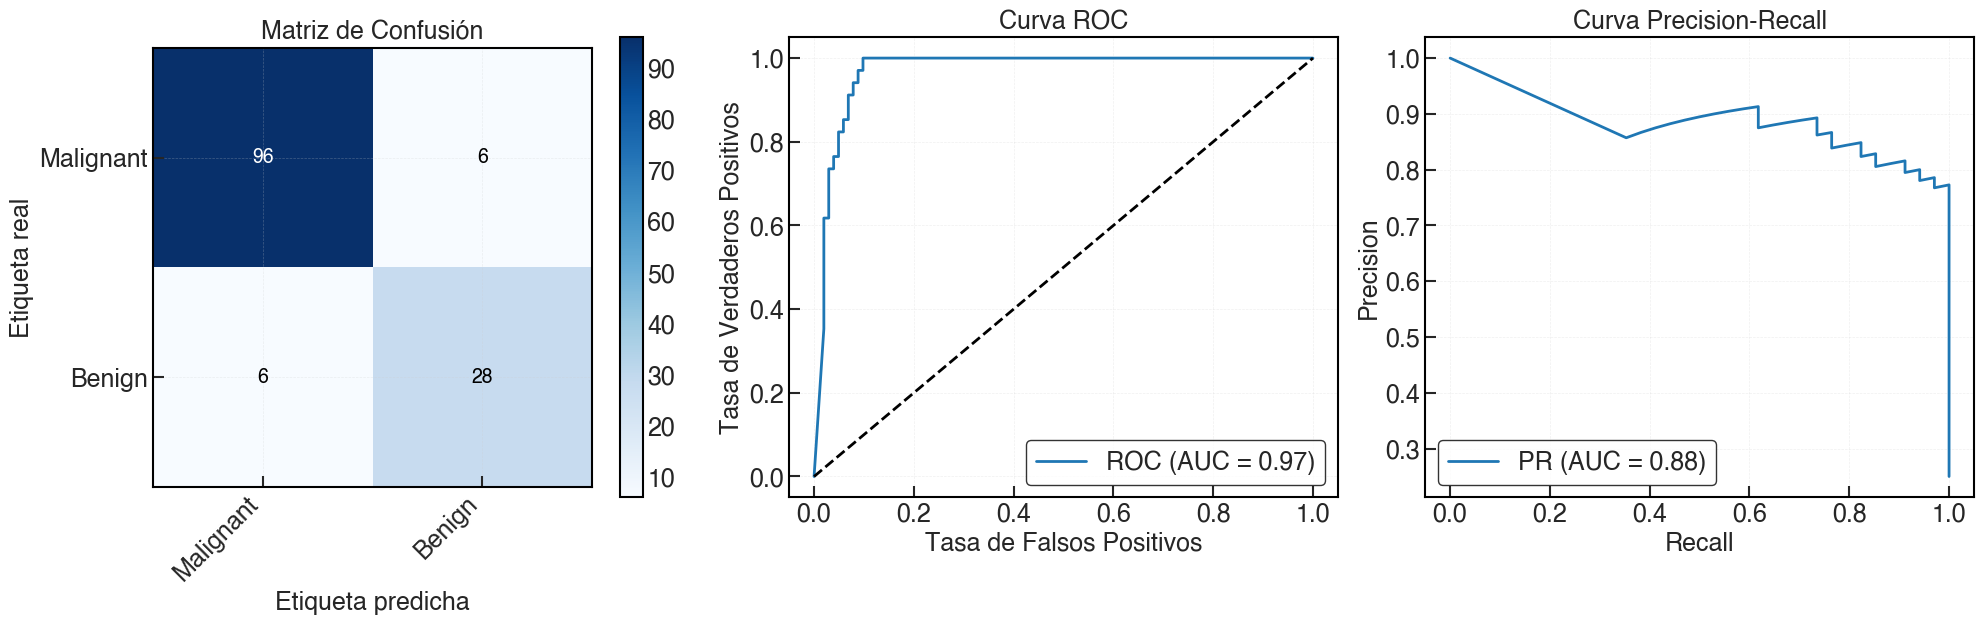

In [149]:

# Evaluar el modelo entrenado en el conjunto de validación
metrics_cost = evaluate_model(
    model=model_cost,
    X_test=X_test_cell_diagnosis_imbalanced,
    y_test=y_test_cell_diagnosis_imbalanced,
    class_names=class_names,
    show_plots=True,
    threshold=0.2,
    figsize=(20, 6),
    print_metrics=True
)


# Punto 2: Análisis del Dataset WAR_class

In [150]:
fig_output_dir_p2 = "./figures/p2"
os.makedirs(fig_output_dir_p2, exist_ok=True)
data_dir_p2 = data_dir / "p2"

In [151]:
config_war_class = DatasetConfig(
    data_dir=data_dir_p2,
    target_column="war_class",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)
loader_war_class = DataLoader(config_war_class)
loader_war_class.read_data(
    dev_file="raw/WAR_class_dev.csv",
    test_file="raw/WAR_class_test.csv",
    splitted=False
)
war_class_dev, war_class_test = loader_war_class.get_pandas_data(splitted=False)

In [152]:
war_class_for_train, war_class_for_valid = train_valid_split(war_class_dev, test_size=0.2, random_state=42)
print("Valores nulos en conjunto de entrenamiento:")
print(war_class_for_train.isnull().sum().sum())
print("Valores nulos en conjunto de validación:")
print(war_class_for_valid.isnull().sum().sum())

Valores nulos en conjunto de entrenamiento:
0
Valores nulos en conjunto de validación:
0


In [153]:
print("WAR_class_train.csv - Información básica:")
print(f"Número de filas: {war_class_for_train.shape[0]}")
print(f"Número de columnas: {war_class_for_train.shape[1]}")
print("\nPrimeras filas del dataset:")
display(war_class_for_train.head())


WAR_class_train.csv - Información básica:
Número de filas: 5426
Número de columnas: 6

Primeras filas del dataset:


poss           mp  raptor_total  war_total  pace_impact  \
4698  1868.699101  1014.148270     -5.007210  -1.502452    -0.095117   
2615  1707.472466   796.174060     -5.836661  -1.035020     0.094600   
149   5567.712437  3045.743338      6.877886  13.557850     0.463237   
2771  2308.445281  1078.276038     -0.146617   1.440371     0.401561   
3628  2567.084771  1105.957572      1.402560   2.551115     0.410492   

      war_class  
4698          1  
2615          2  
149           3  
2771          2  
3628          2

In [154]:
analyze_null_values(
    [war_class_for_train, war_class_test],
    ["conjunto de entrenamiento WAR_class", "conjunto de prueba WAR_class"]
);

Valores nulos en conjunto de entrenamiento WAR_class:


Columna  Cantidad de nulos  Porcentaje (%)
0          poss                  0             0.0
1            mp                  0             0.0
2  raptor_total                  0             0.0
3     war_total                  0             0.0
4   pace_impact                  0             0.0
5     war_class                  0             0.0

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo         0             0.0
1           Muestras sin valores nulos      5426           100.0
2                    Total de muestras      5426           100.0



Valores nulos en conjunto de prueba WAR_class:


Columna  Cantidad de nulos  Porcentaje (%)
0          poss                  0             0.0
1            mp                  0             0.0
2  raptor_total                  0             0.0
3     war_total                  0             0.0
4   pace_impact                  0             0.0
5     war_class                  0             0.0

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo         0             0.0
1           Muestras sin valores nulos      1696           100.0
2                    Total de muestras      1696           100.0

In [155]:
duplicated_rows = war_class_for_train.duplicated().sum()
print(f"Número de filas duplicadas en WAR_class_dev: {duplicated_rows}")

Número de filas duplicadas en WAR_class_dev: 0


In [156]:
analyze_categorical_variables(war_class_for_train, ["war_class"])

Distribución de variables categóricas:

Distribución de war_class:


war_class  Conteo  Porcentaje (%)
0          2    2000           36.86
1          3    1806           33.28
2          1    1620           29.86

In [157]:
numerical_cols_war = war_class_for_train.select_dtypes(include=["number"]).columns.tolist()
numerical_cols_war = [col for col in numerical_cols_war if col != "war_class"]

In [158]:
print("\nCaracterísticas principales:")
for col in numerical_cols_war:
    print(f"  {col}: {war_class_for_train[col].min():.2f} a {war_class_for_train[col].max():.2f} (promedio: {war_class_for_train[col].mean():.2f})")


Características principales:
  poss: -414.39 a 9329.40 (promedio: 3622.14)
  mp: -235.33 a 4264.46 (promedio: 1803.11)
  raptor_total: -43.45 a 32.90 (promedio: -1.48)
  war_total: -6.59 a 28.76 (promedio: 2.78)
  pace_impact: -6.94 a 11.19 (promedio: 0.09)


quitamos valores negativos (los ponemos como NAN y usamos KNN para imputarlos)

In [159]:
X_train_war_class_for_cross_validation = war_class_for_train.drop(columns=["war_class","war_total"])
y_train_war_class_for_cross_validation = war_class_for_train["war_class"].to_numpy()

numerical_cols_to_remove_negatives = ["poss", "mp", "war_total"]
# Apply the function to each dataframe
war_class_for_train_outliers, neg_count_train = remove_negative_values(war_class_for_train, numerical_cols_to_remove_negatives)
war_class_for_valid_outliers, neg_count_valid = remove_negative_values(war_class_for_valid, numerical_cols_to_remove_negatives)
war_class_test, neg_count_test = remove_negative_values(war_class_test, numerical_cols_to_remove_negatives)

# Print results
print(f"Replaced {neg_count_train} negative values in training set")
print(f"Replaced {neg_count_valid} negative values in validation set")
print(f"Replaced {neg_count_test} negative values in test set")

# Now impute missing values
war_class_for_train, war_class_for_valid, war_class_test = impute_missing_values(
    war_class_for_train_outliers,
    war_class_for_valid_outliers,
    war_class_test,
    knn_neighbors=5,
    knn_weights="distance"
)



Replaced 2533 negative values in training set
Replaced 632 negative values in validation set
Replaced 773 negative values in test set
Missing values before imputation:
Train: 2533 missing values
Valid: 632 missing values
Test: 773 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


In [160]:
print("\nCaracterísticas principales:")
for col in numerical_cols_war:
    print(f"  {col}: {war_class_for_train[col].min():.2f} a {war_class_for_train[col].max():.2f} (promedio: {war_class_for_train[col].mean():.2f})")


Características principales:
  poss: 4.24 a 9329.40 (promedio: 3631.79)
  mp: 0.23 a 4264.46 (promedio: 1808.96)
  raptor_total: -43.45 a 32.90 (promedio: -1.48)
  war_total: 0.00 a 28.76 (promedio: 5.93)
  pace_impact: -6.94 a 11.19 (promedio: 0.09)


Gráfico guardado en: ./figures/p2/numerical_distributions_outliers.png


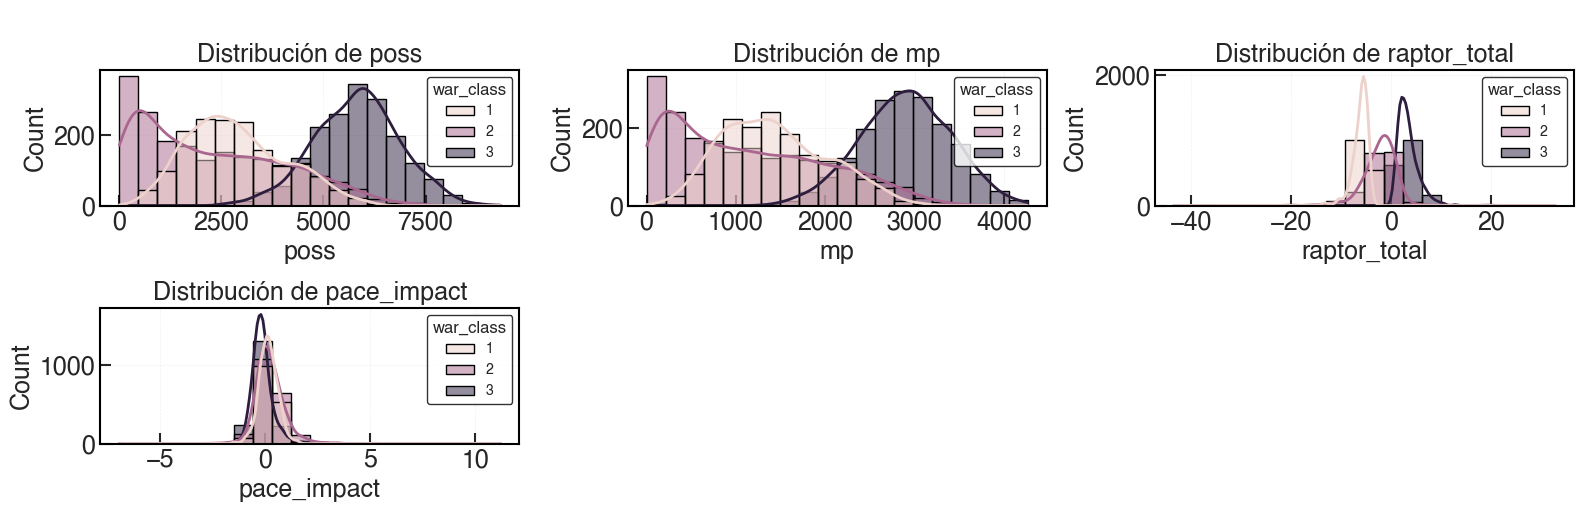

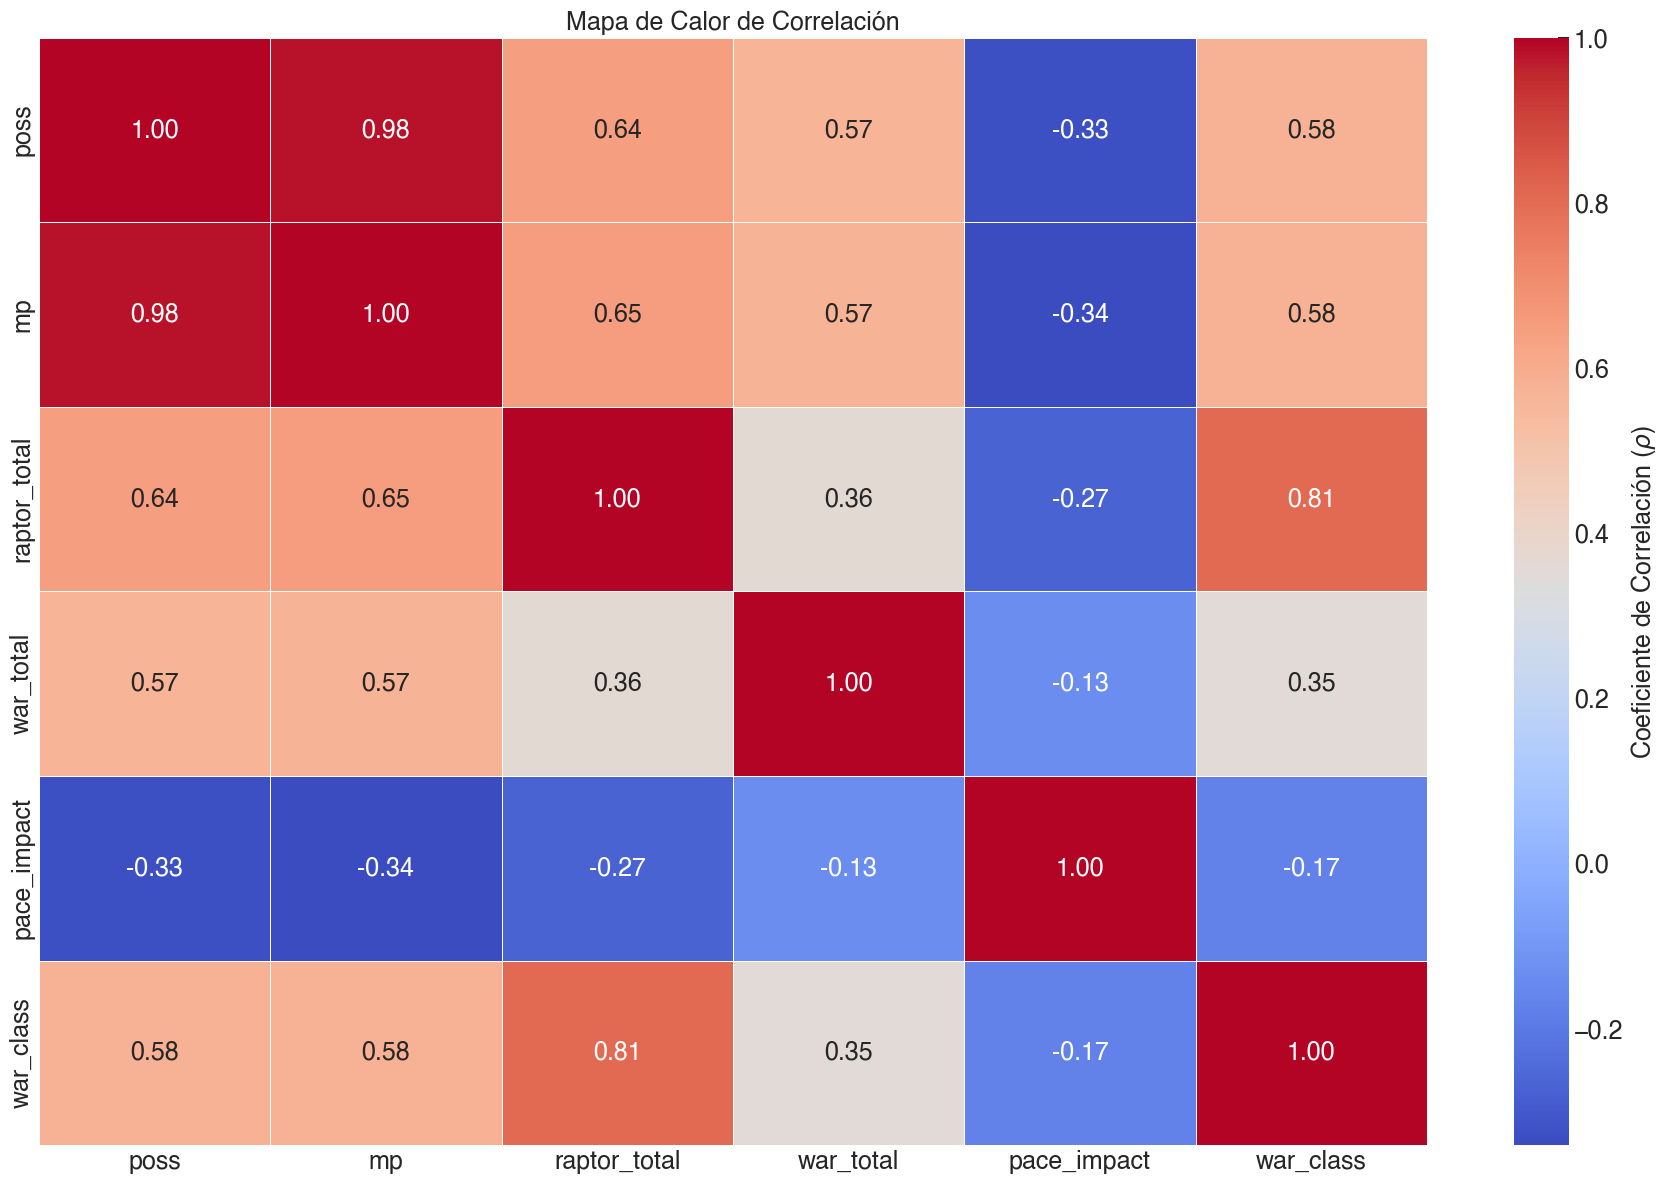

Gráfico guardado en: ./figures/p2/boxplots_outliers_analysis.png


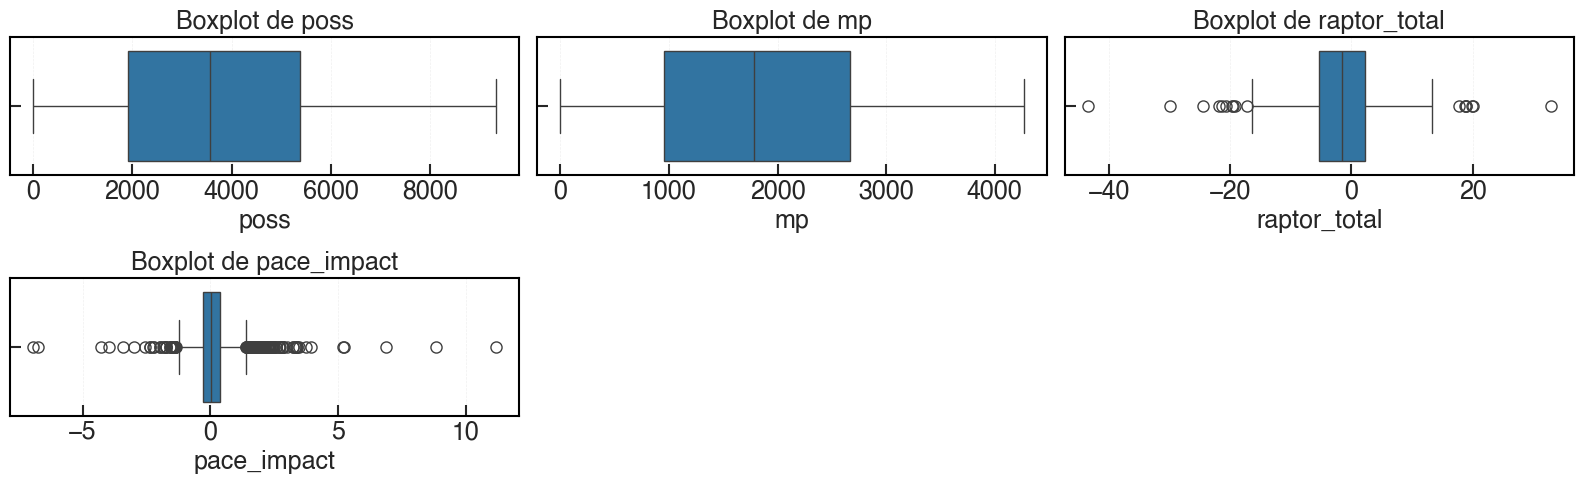

(<Figure size 1600x500 with 4 Axes>,
 <Figure size 1800x1200 with 2 Axes>,
 [<Figure size 1600x500 with 6 Axes>])

In [161]:

FEATURES_TO_PLOT_WAR = ["poss", "mp", "raptor_total", "pace_impact"]

fig_params ={
    "heatmap_params":{
        "label_fontsize":18,
        "title_fontsize":18,
        "tick_fontsize":18,
        "cbar_fontsize":18,
        "annot_fontsize":18,
        # "correlation_method":"pearson",
        "figsize":(18,12)
    },
    "outliers_params":{
        "method":"iqr",
        "target_column":"war_class",
        "return_params":True,
        "figsize":(16,10)
    },
    "numerical_distributions_params":{
        "figsize":(16,5)
    }
}

plot_data_analysis_all_visualizations(
    war_class_for_train,
    numerical_cols_war,
    "war_class",
    FEATURES_TO_PLOT_WAR,
    fig_output_dir_p2,
    fig_output_dir_p2,
    fig_params
)


In [162]:
war_class_for_train, war_iqr_params = replace_outliers_iqr(war_class_for_train, method="winsorize", target_column="war_class",return_params=True)
war_class_for_valid = replace_outliers_iqr(war_class_for_valid, method="winsorize", params=war_iqr_params, target_column="war_class")
war_class_test = replace_outliers_iqr(war_class_test, method="winsorize", params=war_iqr_params, target_column="war_class")




loader_war_class.update(
    df_train=war_class_for_train,
    df_valid=war_class_for_valid,
    df_test=war_class_test
);


In [163]:

data_dict = {
    "df_train":war_class_for_train,
    "df_valid":war_class_for_valid,
    "df_test":war_class_test
}

save_processed_data(
    data_dict=data_dict,
    data_dir=data_dir_p2,
    loader=loader_war_class,
    dataset_name="WAR_class"
)

In [164]:
loader_war_class.read_data(
    train_file="preprocessed/WAR_class_train.csv",
    valid_file="preprocessed/WAR_class_valid.csv",
    test_file="preprocessed/WAR_class_test.csv",
    splitted=True
)
war_class_for_train, war_class_for_valid, war_class_test = loader_war_class.get_pandas_data(splitted=True)

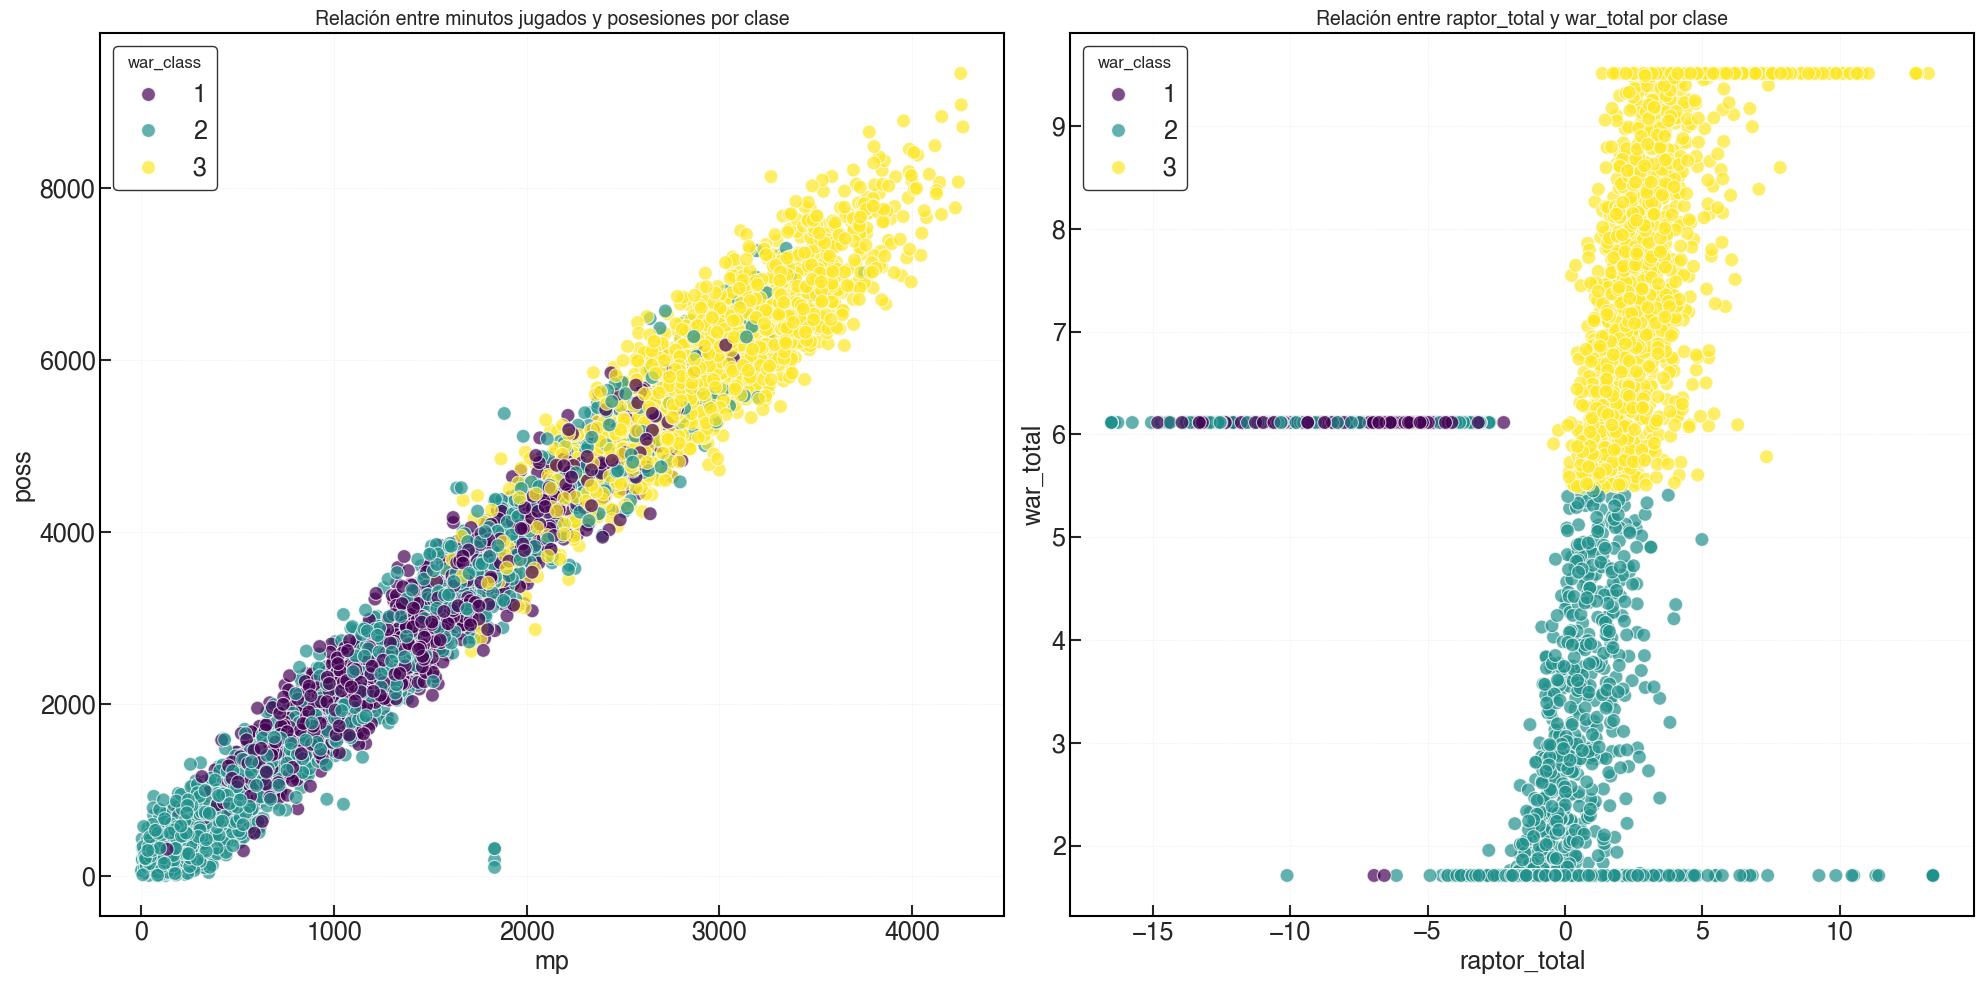

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Primer gráfico: relación entre minutos jugados y posesiones
sns.scatterplot(data=war_class_for_train, x="mp", y="poss", hue="war_class", palette="viridis", s=100, alpha=0.7, ax=axes[0])
axes[0].set_title("Relación entre minutos jugados y posesiones por clase", fontsize=14)
axes[0].grid(True, alpha=0.3)

# Segundo gráfico: relación entre raptor_total y war_total
sns.scatterplot(data=war_class_for_train, x="raptor_total", y="war_total", hue="war_class", palette="viridis", s=100, alpha=0.7, ax=axes[1])
axes[1].set_title("Relación entre raptor_total y war_total por clase", fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(fig_output_dir_p2, "scatter_relationships.png"), dpi=300, bbox_inches="tight")
plt.show()

## Punto 2.2

In [166]:

X_train, y_train, X_valid, y_valid = process_training_data(war_class_for_train, war_class_for_valid, "war_class",encode_categorical=False)


X_test, y_test = loader_war_class.get_processed_test_data(
    encode_categorical=False,
    normalize=False
)

X_test = war_class_test.drop(columns=["war_class","war_total"]).to_numpy()
y_test = war_class_test["war_class"].to_numpy()


In [167]:
X_train_normalized, params = normalize_data(X_train, None, return_params=True)
X_valid_normalized = normalize_data(X_valid, params)
X_test_normalized = normalize_data(X_test, params)

In [168]:
from models.random_forest import RandomForest, RandomForestConfig
from models.lda import LDA, LDAConfig

Accuracy: 0.9233
Precision: 0.9312
Recall: 0.9233
F1 Score: 0.9216


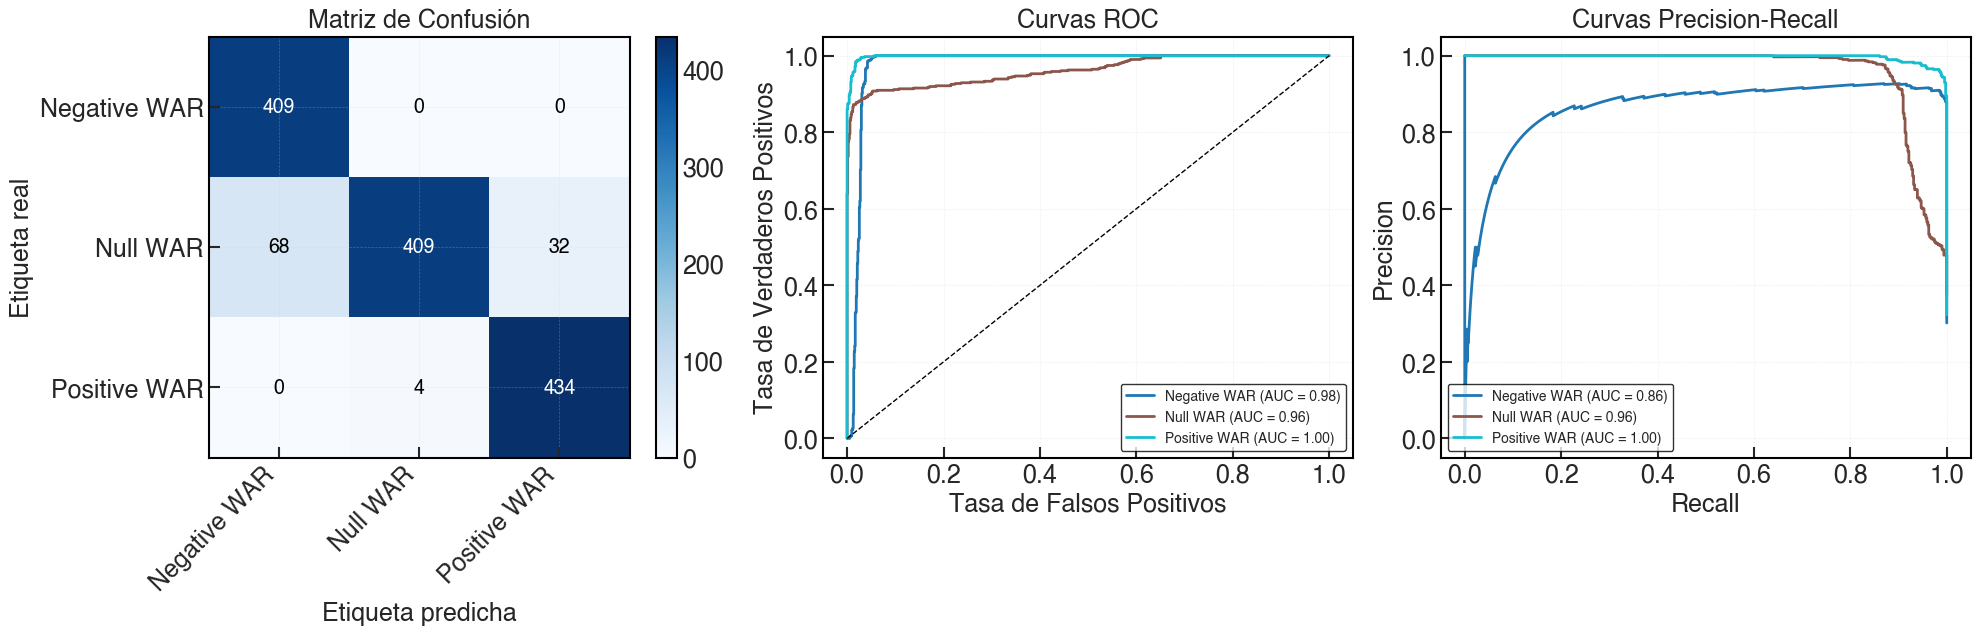

In [169]:

lda_config = LDAConfig(solver="svd")
lda_model = LDA(lda_config)
lda_model.fit(X_train_normalized, y_train)




evaluate_model(
    model=lda_model,
    X_test=X_valid_normalized,
    y_test=y_valid,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],  # Real class names
    save_dir=fig_output_dir_p2,
    base_filename="lda",
    figsize=(20, 6)
);






Lambda: 0.0001, Aggregated F1 Score: 0.5005
Lambda: 0.0004, Aggregated F1 Score: 0.5005
Lambda: 0.0013, Aggregated F1 Score: 0.5005
Lambda: 0.0046, Aggregated F1 Score: 0.5005
Lambda: 0.0167, Aggregated F1 Score: 0.5005
Lambda: 0.0599, Aggregated F1 Score: 0.5005
Lambda: 0.2154, Aggregated F1 Score: 0.5005
Lambda: 0.7743, Aggregated F1 Score: 0.5005
Lambda: 2.7826, Aggregated F1 Score: 0.5005
Lambda: 10.0000, Aggregated F1 Score: 0.5004
Accuracy: 0.5900
Precision: 0.4103
Recall: 0.5900
F1 Score: 0.4828


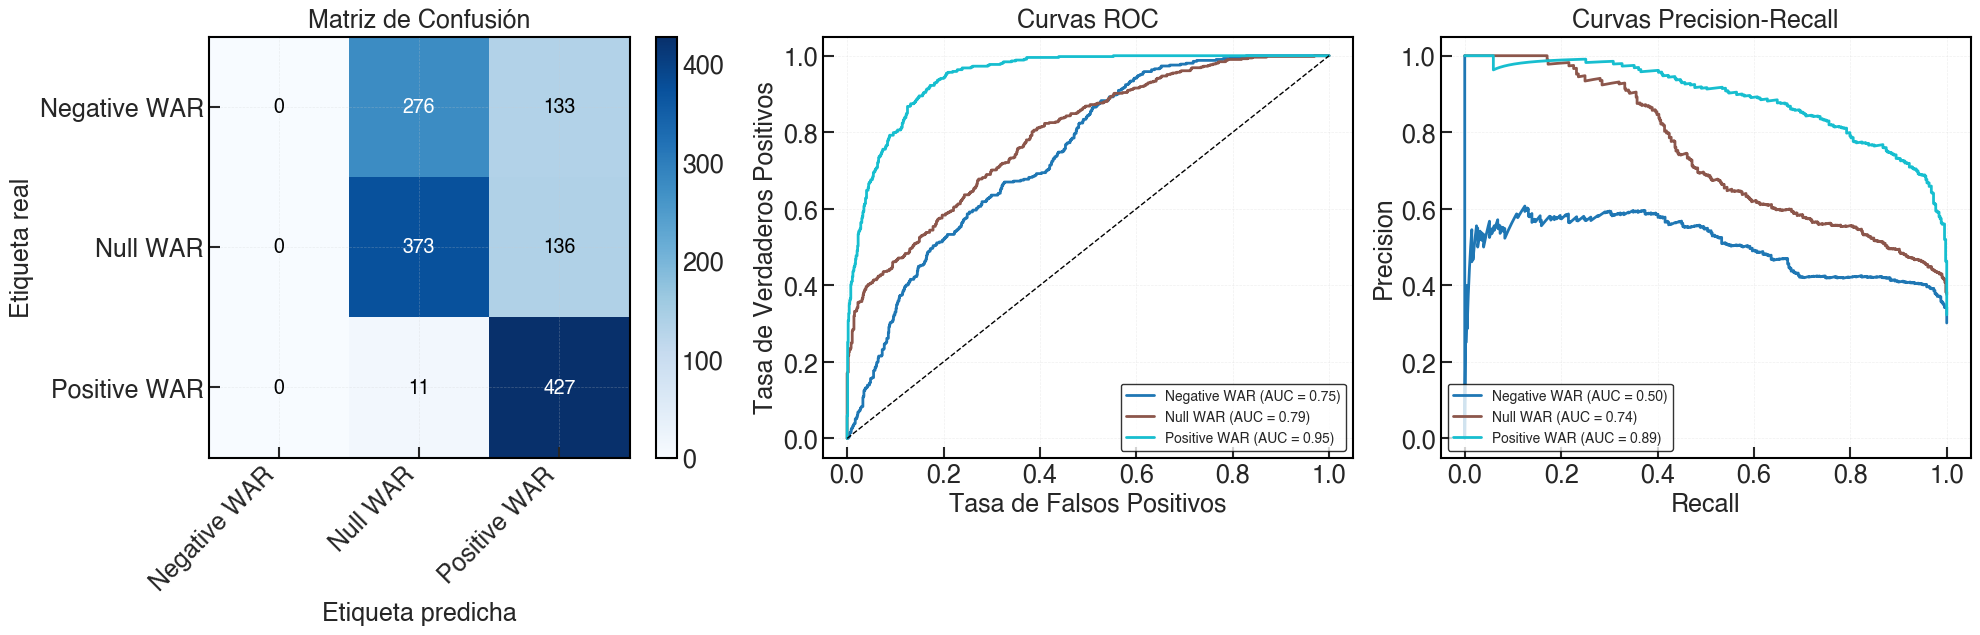

In [170]:
lambda_values = np.logspace(-4, 1, 10)

best_lambda_multiclass_logistic_regression, cv_scores = cross_validate_lambda(
    X=X_train_normalized,
    y=y_train,
    lambda_values=lambda_values,
    categorical_columns=[],
    metric_fn=f1_score,
    k_folds=5,
    average="weighted",
    verbose=True,
    threshold=0.2,
    aggregate_predictions=True,
    resampler=None
)


multiclass_logistic_regression_config = LogisticRegressionConfig(
    lambda_reg=best_lambda_multiclass_logistic_regression,
    max_iter=1000,
    tol=1e-4,
    learning_rate=0.01
)


model_multiclass_logistic_regression = LogisticRegression(multiclass_logistic_regression_config)

model_multiclass_logistic_regression.fit(X_train_normalized, y_train)

result_multiclass_logistic_regression = evaluate_model(
    model=model_multiclass_logistic_regression,
    X_test=X_valid_normalized,
    y_test=y_valid,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="multiclass_logistic_regression",
    figsize=(20, 6),
    average="weighted"
)

Accuracy: 0.9830
Precision: 0.9834
Recall: 0.9830
F1 Score: 0.9831


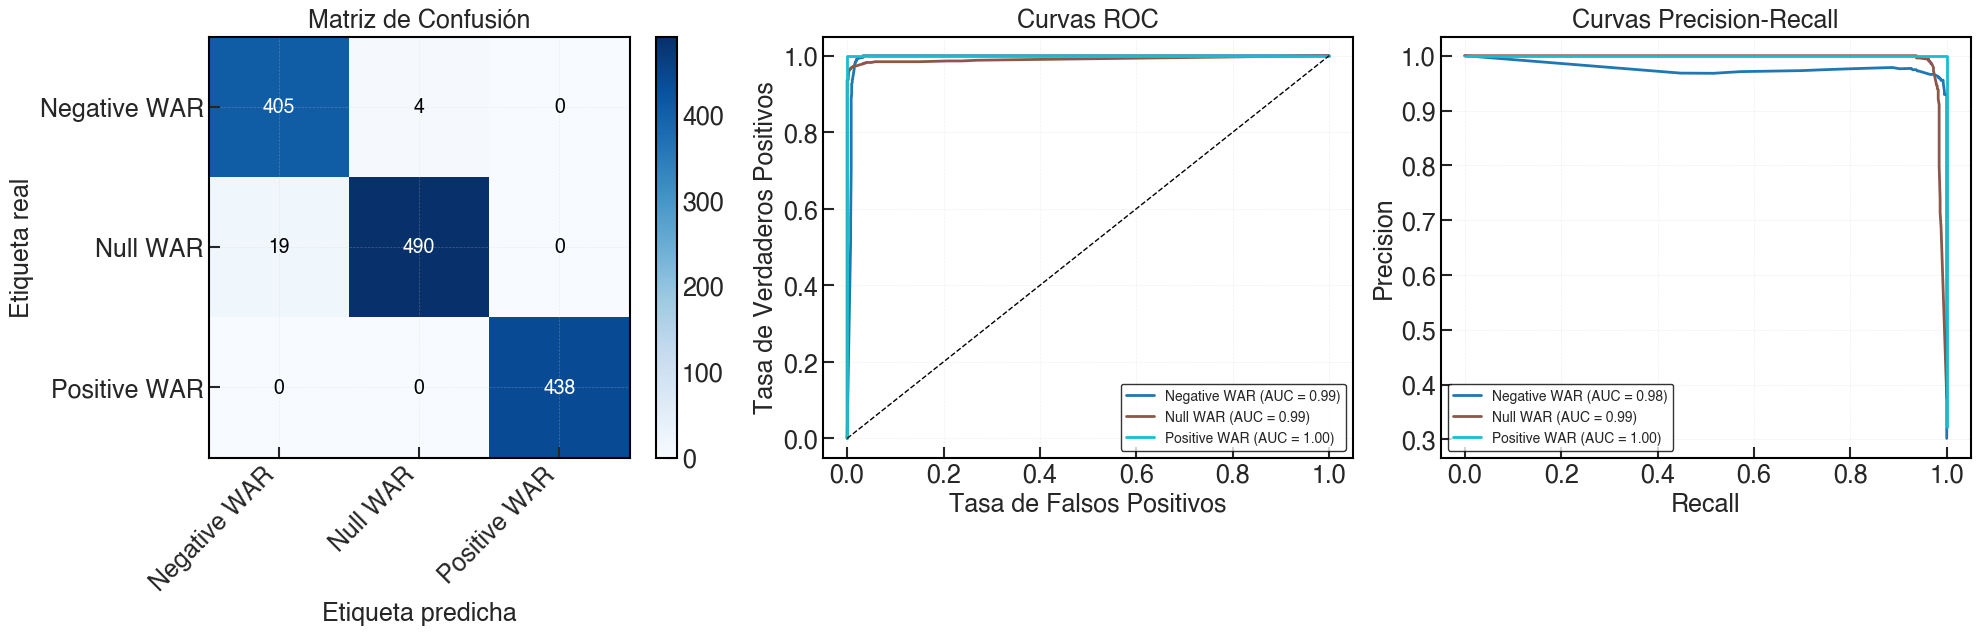

In [171]:
random_forest_config = RandomForestConfig(
    n_estimators=3,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    criterion="entropy"
)

model_random_forest = RandomForest(random_forest_config)

model_random_forest.fit(X_train, y_train)


result_random_forest = evaluate_model(
    model=model_random_forest,
    X_test=X_valid,
    y_test=y_valid,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="random_forest",
    figsize=(20, 6),
    average="weighted"
)




## Punto 2.4

In [172]:
# Combine training and validation sets



war_class_dev, neg_count_war_class_dev = remove_negative_values(war_class_dev, numerical_cols_to_remove_negatives)

war_class_dev = impute_missing_values(
    war_class_dev,
    knn_neighbors=5,
    knn_weights="distance"
)


war_class_dev = replace_outliers_iqr(
    war_class_dev,
    method="iqr",
    target_column="war_class"
)


X_train_war_class_dev, y_train_war_class_dev = war_class_dev.drop(columns=["war_class","war_total"]), war_class_dev["war_class"]

X_test, y_test = war_class_test.drop(columns=["war_class","war_total"]), war_class_test["war_class"]




X_train_full_dev_normalized, params = normalize_data(X_train_war_class_dev, None, return_params=True)
X_test_full_dev_normalized = normalize_data(X_test, params)
y_test_full_dev = y_test

X_test_full_dev_normalized = X_test_full_dev_normalized.to_numpy()
X_train_full_dev_normalized = X_train_full_dev_normalized.to_numpy()
y_test_full_dev = y_test_full_dev.to_numpy()
y_train_war_class_dev = y_train_war_class_dev.to_numpy()


Missing values before imputation:
Train: 3165 missing values

Missing values after imputation:
Train: 0 missing values


Gráfico guardado en: ./figures/p2/numerical_distributions_outliers.png


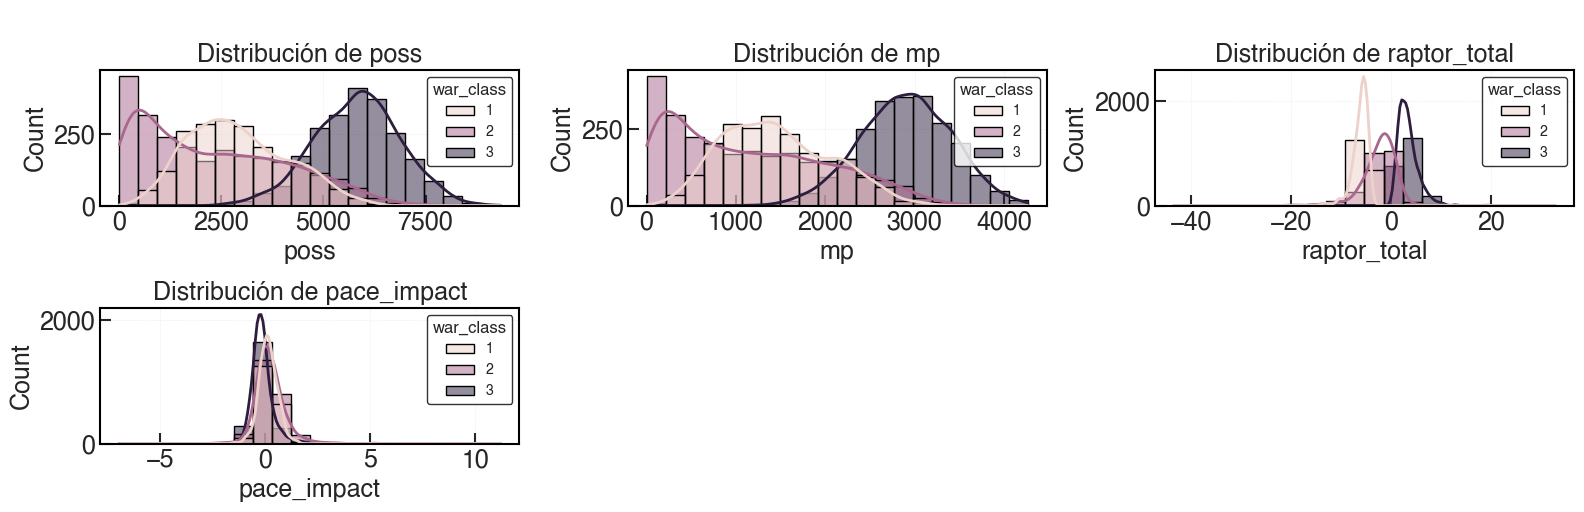

Gráfico guardado en: ./figures/p2/correlation_heatmap_numerical_features_outliers.png


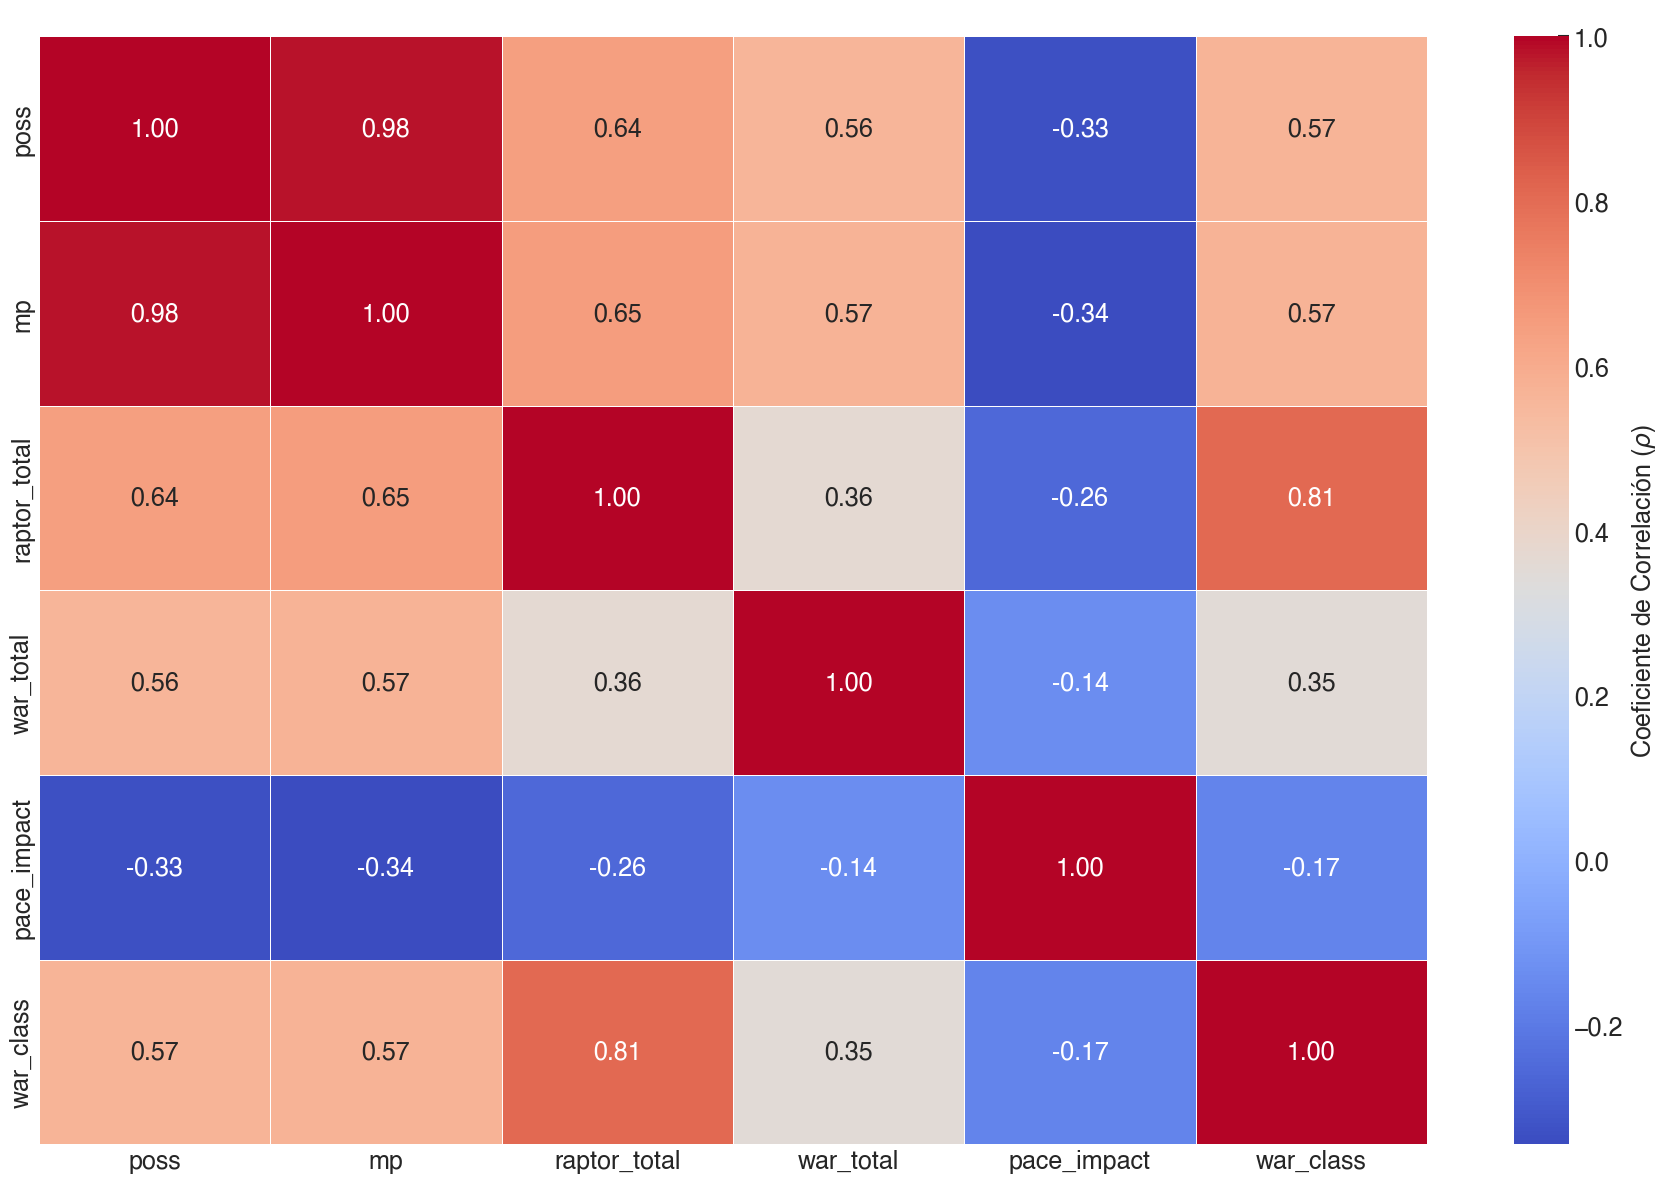

Gráfico guardado en: ./figures/p2/boxplots_outliers_analysis.png


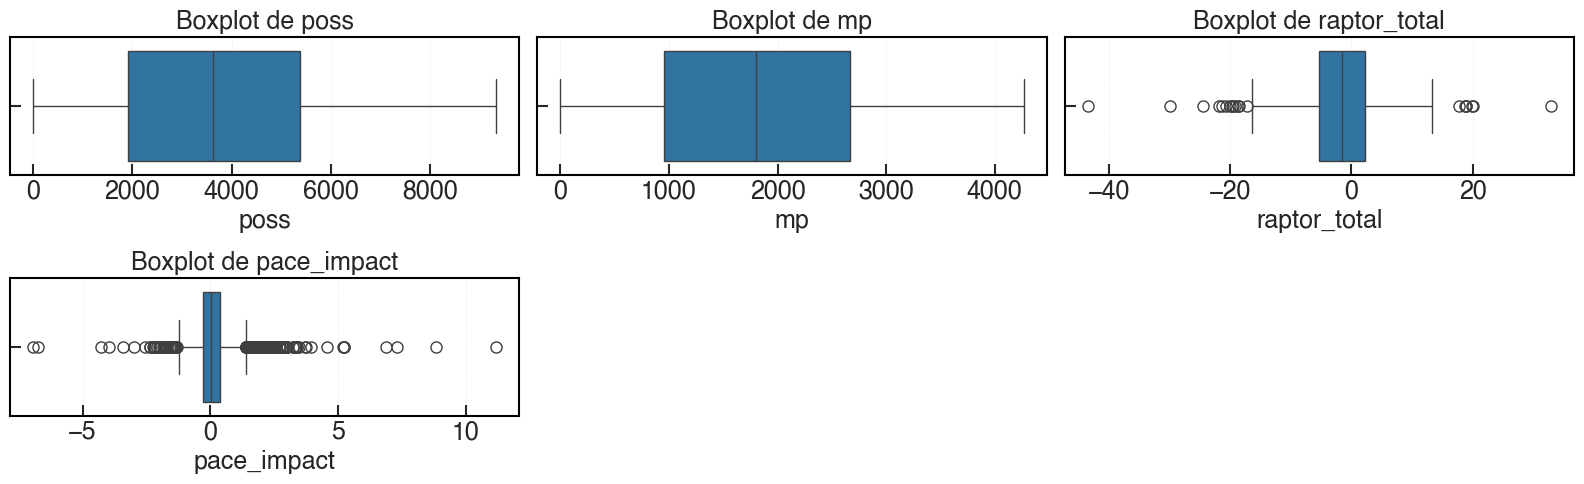

(<Figure size 1600x500 with 4 Axes>,
 <Figure size 1800x1200 with 2 Axes>,
 [<Figure size 1600x500 with 6 Axes>])

In [173]:
plot_data_analysis_all_visualizations(
    war_class_dev,
    numerical_cols_war,
    "war_class",
    FEATURES_TO_PLOT_WAR,
    fig_output_dir_p2,
    fig_output_dir_p2
)

Accuracy: 0.9045
Precision: 0.9141
Recall: 0.9045
F1 Score: 0.9013


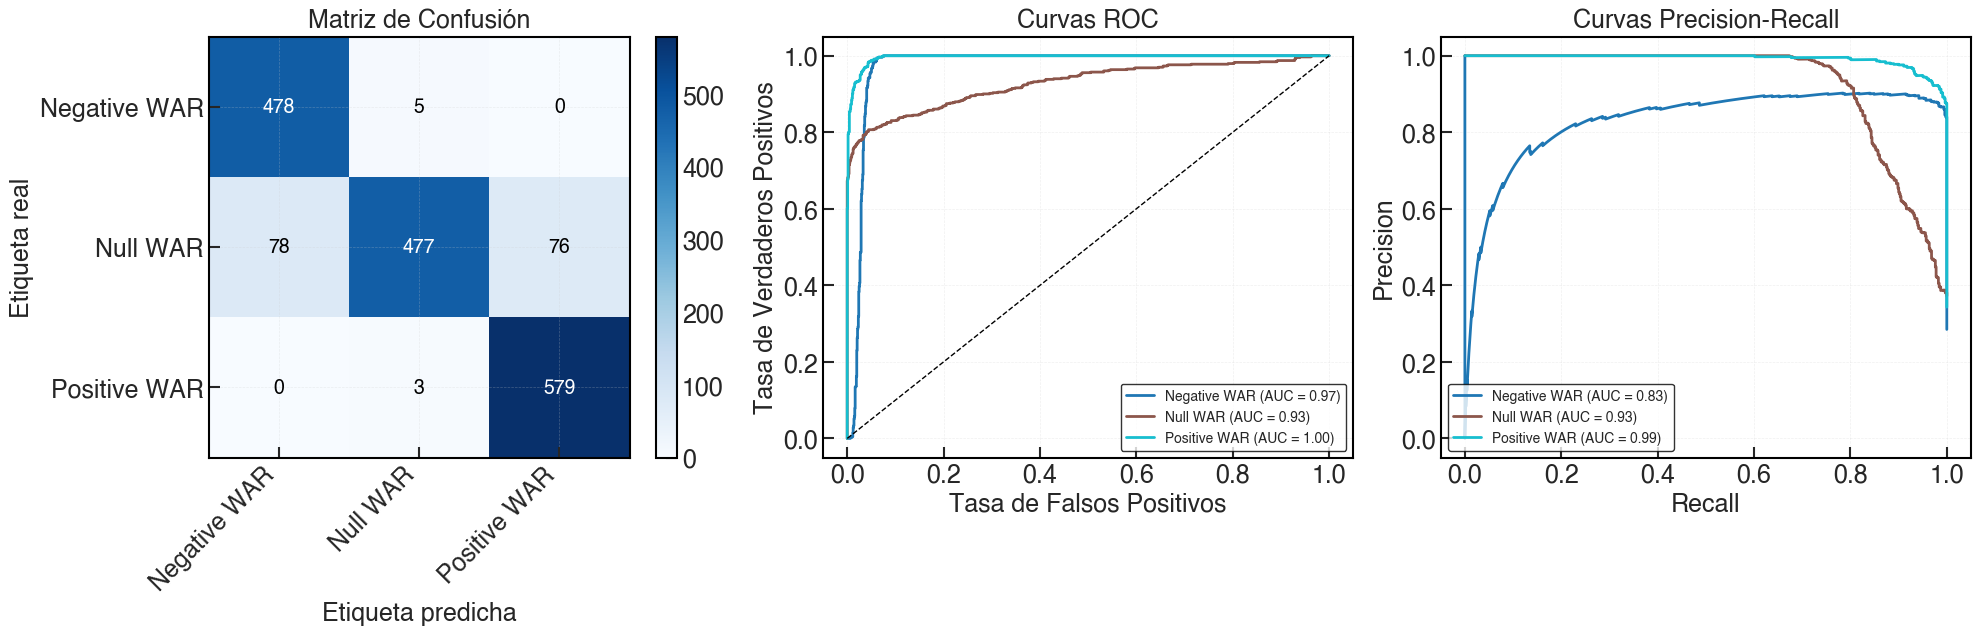

In [174]:

lda_config = LDAConfig(solver="svd")
lda_model = LDA(lda_config)
lda_model.fit(X_train_full_dev_normalized, y_train_war_class_dev)



evaluate_model(
    model=lda_model,
    X_test=X_test_full_dev_normalized,
    y_test=y_test_full_dev,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],  # Real class names
    save_dir=fig_output_dir_p2,
    base_filename="lda",
    figsize=(20, 6)
);






Accuracy: 0.8874
Precision: 0.8956
Recall: 0.8874
F1 Score: 0.8836


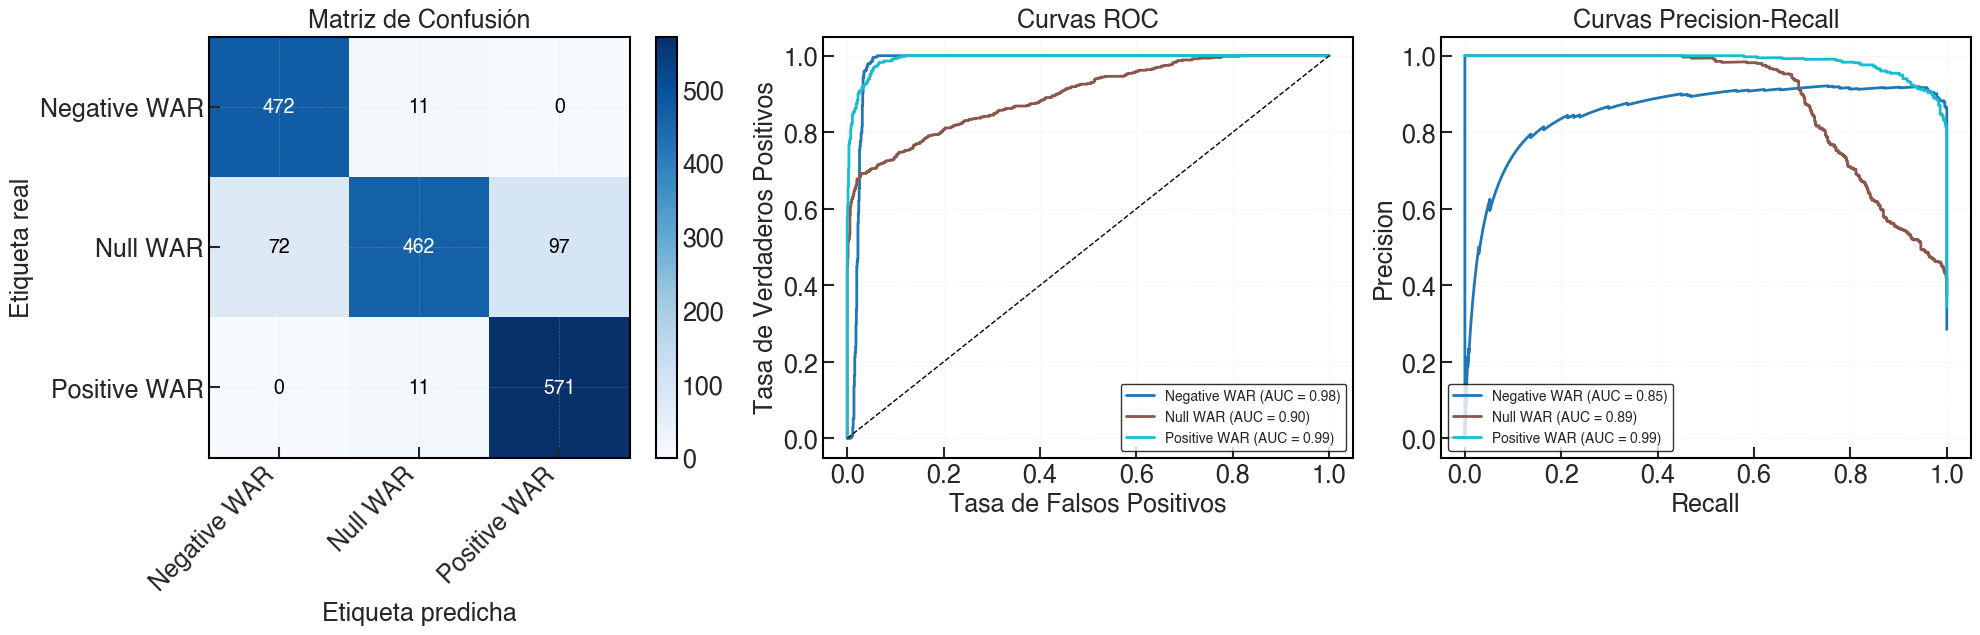

In [175]:




best_lambda_multiclass_logistic_regression, cv_scores = cross_validate_lambda(
    X=X_train_war_class_for_cross_validation,
    y=y_train_war_class_for_cross_validation,
    lambda_values=lambda_values,
    metric_fn=f1_score,
    normalize=True,
    k_folds=5,
    average="weighted",
    verbose=False,
    threshold=0.2,
    aggregate_predictions=True,
    resampler=None
)


multiclass_logistic_regression_config = LogisticRegressionConfig(
    lambda_reg=best_lambda_multiclass_logistic_regression,
    max_iter=1000,
    tol=1e-4,
    learning_rate=0.01
)


model_multiclass_logistic_regression = LogisticRegression(multiclass_logistic_regression_config)

model_multiclass_logistic_regression.fit(X_train_full_dev_normalized, y_train_war_class_dev)

result_multiclass_logistic_regression = evaluate_model(
    model=model_multiclass_logistic_regression,
    X_test=X_test_full_dev_normalized,
    y_test=y_test_full_dev,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="multiclass_logistic_regression",
    figsize=(20, 6),
    average="weighted"
)

Accuracy: 0.9581
Precision: 0.9581
Recall: 0.9581
F1 Score: 0.9580


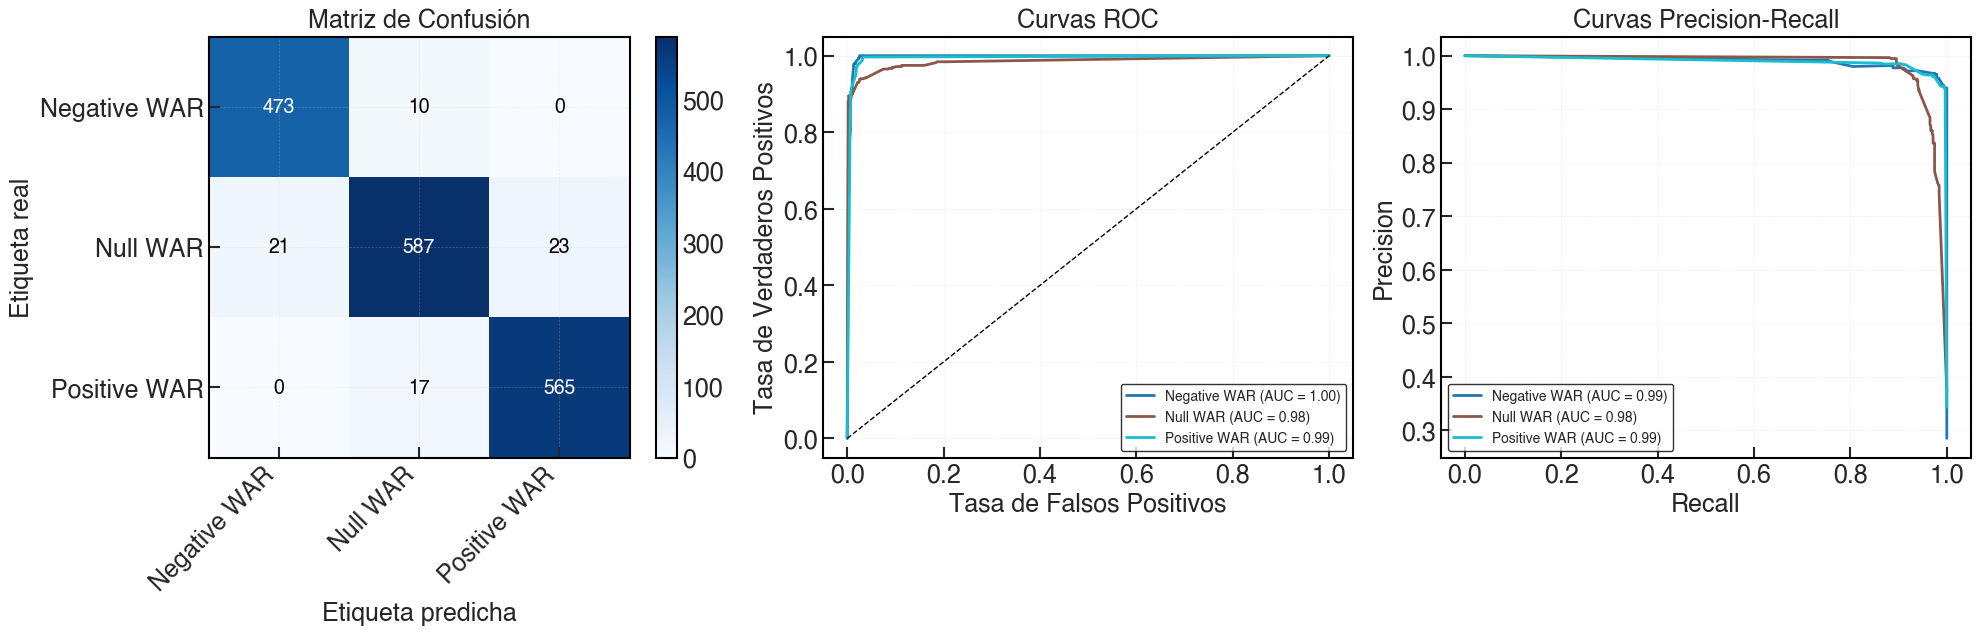

In [176]:
# print shapes


random_forest_config = RandomForestConfig(
    n_estimators=3,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    criterion="entropy"
)

model_random_forest = RandomForest(random_forest_config)

model_random_forest.fit(X_train_full_dev_normalized, y_train_war_class_dev)

result_random_forest = evaluate_model(
    model=model_random_forest,
    X_test=X_test_full_dev_normalized,
    y_test=y_test_full_dev,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="random_forest",
    figsize=(20, 6),
    average="weighted"
)



